## <font color=#0099CC>mIAx - Taller Renta Fija - ANÁLISIS CARTERA DE RENTA FIJA</font>

En esta práctica, desarrollaremos un análisis relativamente exahustivo de un universo de Renta Fija, en concreto, de bonos corporativos. Además, construiremos y analizaremos varias carteras. 

Para ello, contaremos con la siguiente información almacenada en la carpeta *data*:
- Universo de bonos, con sus características esenciales (fichero *universo.csv*)
- Histórico de precios de cierre del universo de bonos anterior (fichero *precios_historicos_universo.csv*)
- Curva de tipos de interés €STR (fichero *curvaESTR.csv*)
- Histórico de precios de otros índices que nos serán de utilidad (fichero *precios_historicos_varios*):
    - Índices de crédito: ITRAXX Main y ITRAXX XOVER. Serán útiles para la cobertura del riesgo de crédito.
    - Futuros sobre el *Schatz* (DU1), *BOBL* (OE1) y *BUND* (RX1). Serán útiles para la cobertura de los tipos de interés.
    - Índice de crédito *RECMTREU*, que valdría como benchmark de las carteras que construyamos.

No necesariamente se usará toda toda la información

En líneas generales, estos son los ejercicios que completaremos, aunque los detallaremos más en cada apartado:
1. Análisis de datos. En esta sección, haremos un análisis de la información que tenemos de cada bono y lo que significa. Asimismo, haremos los tratamientos y limpieza que necesitemos para luego poder usarlos.
2. Valoración de los bonos del universo utilizando la curva de descuento y bajo ciertas asunciones. Comparación de estos precios con los precios de mercado.
3. Cálculo del spread que pagan los bonos sobre la curva.
4. Cálculo de *yield*, duración y convexidad.
5. Contrucción de una cartera equiponderada con todos los bonos del universo. Contraste con el benchmark (os proponemos el índice RECMTREU para el que os hemos dado los precios) y backtest de la estrategia. ¡OJO! El índice es *Total Return*.
6. Tienes el mandato de construir una cartera de como máximo **20** bonos corporativos con ese universo y una serie de restricciones y, claro, maximizando la rentabilidad total de la cartera:
    - La duración de la cartera no debe superar los 3 años
    - La exposición a emisiones HY no puede superar el 10% de la cartera
    - No puedes invertir en deuda subordinada
    - No se puede invertir en emisiones de tamaño igual o inferior a 500 millones
    - No se puede invertir más de un 10% del capital en una misma emisión
    - No puede haber más de un 15% de concentración en un mismo emisor
    (¡OJO! No estamos teniendo en cuenta en este ejercicio si hubiera un mínimo de inversión, lo cuál sería un dato relevante tener en cuenta en un caso real)

    6.1. Constrúyela a fecha de hoy

    6.2. Teniendo en cuenta la naturaleza que nos están pidiendo para la cartera, ¿añadirías alguna otra restricción?

    6.3. ¿Cómo medirías el riesgo de crédito de la cartera?

    6.4. ¿Cómo medirías el riesgo de liquidez de la cartera?

    6.5. Describe cómo habría que hacer el backtest de esta cartera
7. Ahora, se te pide que cubras la exposición de la cartera a los tipos de interés. Con la información que tienes, ¿cómo lo harías?
8. ¿Y si quisieras cubrir total o parcialmente el riesgo de crédito? Usa de nuevo la información que tienes.
9. ¿Cómo construirías tu cartera? ¿Se te ocurre alguna estrategia específica, por ejemplo, de valor relativo?


📣 <font color=#CC6600>**¡NORMAS!**</font>

La práctica se puede hacer en grupos de hasta **3 personas** y deberá entregarse antes del **27 de noviembre**. 

Cada grupo expondrá una parte de los ejercicios en la clase del día 27, donde la resolveremos juntos a modo de taller. Esta exposición contará hasta **1 punto** de la nota final.

Además, se valorará positivamente para la práctica la participación en las clases.

📣 <font color=#CC6600>**¡IMPORTANTE!**</font>

Todo el código implementado debe estar debidamente comentado e incluir conclusiones de los resultados obtenidos para optar a la máxima puntuación. Asimismo, se debe responder a las preguntas planteadas.

Las propuestas de mejora o posibles trabajos futuros se valorarán positivamente también.

Usa las fuentes de información que consideres necesarias para apoyar tus respuestas.

### <font color=#336699>Librerías</font>

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import numpy as np
from scipy import interpolate
from scipy.optimize import fsolve

In [15]:
# Estilo
plt.style.use('dark_background')

In [16]:
# Fecha de análisis
fecha_analisis = pd.to_datetime('2025-10-01')

### <font color=#336699>1. Datos</font>

<style>.gray {background-color: #595959}

</style><div class="gray">❕💬¿Qué observas en los datos? Analiza la información que tenemos del universo</div>

Haz un primer análisis visual de la información que tenemos del universo de bono.
Entre otras, plantéate cuestiones como:
- ¿Divisas?
- ¿Tipo de bonos? ¿Fijo/Flotante? ¿Prelación? ¿Opcionalidad? ¿Hay bonos perpetuos?
- ¿Sectores? ¿Emisores? Si invirtéramos en todos los bonos, ¿dirías a priori que la cartera está diversificada?
- ¿Ratings? (Riesgo de crédito)
- ¿Otros datos cuantitativos?
    - Riesgo de liquidez - Horquillas y nominal vivo
- ¿Hay *gaps* en la información que vamos a tener que tratar?

In [17]:
# Cargamos el universo de bonos
universo = pd.read_csv('../data/universo.csv', sep=';', decimal='.')

'''
 INFORMACIÓN BÁSICA DEL DATASET
 --------------------------------------------------------------------------
 Mostramos estadísticas básicas para entender la estructura de los datos:
 - Total de bonos disponibles
 - Lista de columnas (variables) disponibles
 - Primeras filas para ver un ejemplo de los datos
 - Imprimmimos valores nulos por columna 
    - Alertas específicas para columnas críticas (Maturity, Price)
'''

def reportar_gaps_informacion(df, nombre_dataset):
    """
    Analiza un DataFrame e imprime un reporte de las columnas que contienen valores nulos (NaN/NaT).
    Muestra la cantidad absoluta y el porcentaje respecto al total.
    """
    print(f"\n{'='*60}")
    print(f" ANÁLISIS DE VALORES NULOS: {nombre_dataset}")
    print(f"{'='*60}")
    
    # Calcular nulos y porcentajes
    total_filas = len(df)
    nulos = df.isnull().sum()
    nulos = nulos[nulos > 0] # Filtramos solo las columnas que tienen nulos
    
    if nulos.empty:
        print(f" No se encontraron valores nulos en '{nombre_dataset}'.")
        return
    
    porcentaje = (nulos / total_filas) * 100
    
    # Crear DataFrame para visualizar mejor
    df_nulos = pd.DataFrame({
        'Tipo de Dato': df[nulos.index].dtypes,
        'Cantidad Nulos': nulos,
        'Porcentaje (%)': porcentaje.round(2)
    })
    
    # Ordenar de mayor a menor cantidad de nulos
    df_nulos = df_nulos.sort_values(by='Cantidad Nulos', ascending=False)
    
    print(f"Total de filas: {total_filas}")
    print(f"Columnas con datos faltantes: {len(df_nulos)}")
    print("-" * 60)
    print(df_nulos)
    
    # Alertas específicas para columnas críticas
    if 'Maturity' in df_nulos.index:
        print(f"\n ALERTA CRÍTICA: Faltan fechas de vencimiento en {df_nulos.loc['Maturity', 'Cantidad Nulos']} bonos.")
    if 'Price' in df_nulos.index:
        print(f" ALERTA CRÍTICA: Faltan precios en {df_nulos.loc['Price', 'Cantidad Nulos']} bonos.")



print(f"Total de bonos en el universo: {len(universo)}")
print(f"\nColumnas disponibles: {list(universo.columns)}")
if 'universo' in locals():
    reportar_gaps_informacion(universo, "Universo de Bonos")


Total de bonos en el universo: 2255

Columnas disponibles: ['ISIN', 'Description', 'Ccy', 'Price', 'Issuer', 'Industry Sector', 'Maturity', 'Coupon', 'Rating', 'PD 1YR', 'Outstanding Amount', 'Callable', 'Next Call Date', 'Seniority', 'Coupon Frequency', 'Coupon Type', 'First Coupon Date', 'Penultimate Coupon Date', 'Issue date', 'Bid Price', 'Ask Price']

 ANÁLISIS DE VALORES NULOS: Universo de Bonos
Total de filas: 2255
Columnas con datos faltantes: 5
------------------------------------------------------------
                        Tipo de Dato  Cantidad Nulos  Porcentaje (%)
Next Call Date                object             615           27.27
PD 1YR                       float64              24            1.06
Maturity                      object              19            0.84
Penultimate Coupon Date       object              19            0.84
Rating                        object               1            0.04

 ALERTA CRÍTICA: Faltan fechas de vencimiento en 19 bonos.


Tras el análisis de vlores nulos encontrados en el documento "universo.csv" nos encontramos que:

1.- Hay 615 valores nulos en la columna " Next Call Date" seguramente por que estos no sean bonos "Callable".

2.- Faltan 24 datos de Probabilidad de Default a 1 año. Si queremos calcular el riesgo de crédito o pérdida esperada, estos bonos darán error.

3.- Hay 19 bonos con "Maturity" nula. Seguramente sean bonos prepetuos, pero si queremos calcular la duración o el rendimiento a vencimiento (YTM), se tendrá que imponer alguna condición.

4.- Hay un valor con rating nulo.

También habrá que convertir las fechas a formato "datetime" y convertir a booleano la columna "Callable" para poder operar con estos valores.

In [18]:
# Limpieza básica tras la carga del universo
#Cambiamos a formato datetime los campos de fecha y reemplazamos strings vacíos por NaN
campos_fecha = ['Maturity', 'Next Call Date', 'First Coupon Date', 'Penultimate Coupon Date', 'Issue date']
for campo in campos_fecha:
    if campo in universo.columns:
        universo[campo] = universo[campo].replace('', pd.NA)
        universo[campo] = pd.to_datetime(universo[campo], errors='coerce')

# Converimos a booleano la columna Callable
if 'Callable' in universo.columns:
    universo['Callable'] = (universo['Callable']
                            .fillna('N')
                            .astype(str)
                            .str.upper()
                            .str.strip())

display(universo.head(10))

C:\Users\1jose\AppData\Local\Temp\ipykernel_7056\3762119236.py:7: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  universo[campo] = pd.to_datetime(universo[campo], errors='coerce')
C:\Users\1jose\AppData\Local\Temp\ipykernel_7056\3762119236.py:7: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  universo[campo] = pd.to_datetime(universo[campo], errors='coerce')
C:\Users\1jose\AppData\Local\Temp\ipykernel_7056\3762119236.py:7: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  universo[campo] = pd.to_datetime(universo[campo], errors='coerce')
C:\Users\1jose\AppData\Local\Temp\ipykernel_7056\3762119236.py:7: UserWarning: Parsing dates in %d/%m/%Y format 

,ISIN,Description,Ccy,Price,Issuer,Industry Sector,Maturity,Coupon,Rating,PD 1YR,...,Callable,Next Call Date,Seniority,Coupon Frequency,Coupon Type,First Coupon Date,Penultimate Coupon Date,Issue date,Bid Price,Ask Price
0,XS0161488498,DT 7 ½ 01/24/33,EUR,127.8353,DEUTSCHE TELEKOM INT FIN,Communications,2033-01-24,7.500,BBB+,2.196619e-02,...,N,NaT,Sr Unsecured,1,FIXED,2004-01-24,2032-01-24,2003-01-24,127.462,128.208
1,FR0000471930,ORAFP 8 ⅛ 01/28/33,EUR,131.3195,ORANGE SA,Communications,2033-01-28,8.125,BBB+,2.142390e-05,...,N,NaT,Sr Unsecured,1,FIXED,2004-01-28,2032-01-28,2003-01-28,130.991,131.648
2,XS0162513211,EOANGR 5 ¾ 02/14/33,EUR,115.7800,E.ON INTL FINANCE BV,Utilities,2033-02-14,5.750,BBB+,1.008200e-04,...,N,NaT,Sr Unsecured,1,FIXED,2004-02-14,2032-02-14,2003-02-14,115.447,116.114
3,XS0162869076,TELEFO 5 ⅞ 02/14/33,EUR,116.3000,TELEFONICA EUROPE BV,Communications,2033-02-14,5.875,BBB-,1.249580e-04,...,N,NaT,Sr Unsecured,1,FIXED,2004-02-14,2032-02-14,2003-02-14,115.984,116.616
4,FR0010014845,PEUGOT 6 09/19/33,EUR,112.3887,PSA TRESORERIE GIE,"Consumer, Cyclical",2033-09-19,6.000,BBB,2.423967e-02,...,N,NaT,Sr Unsecured,1,FIXED,2004-09-19,2032-09-19,2003-09-19,111.839,112.938
5,FR0010033381,VIEFP 6 ⅛ 11/25/33,EUR,119.7020,VEOLIA ENVIRONNEMENT SA,Utilities,2033-11-25,6.125,BBB,2.005240e-04,...,N,NaT,Sr Unsecured,1,FIXED,2004-11-25,2032-11-25,2003-11-25,119.299,120.105
6,XS0229567440,GE 4 ⅛ 09/19/35,EUR,105.4562,GENERAL ELECTRIC CO,Industrial,2035-09-19,4.125,A-,5.118290e-06,...,N,NaT,Sr Unsecured,1,FIXED,2006-09-19,2034-09-19,2005-09-19,105.115,105.798
7,XS0300113254,PG 4 ⅞ 05/11/27,EUR,104.0970,PROCTER & GAMBLE CO/THE,"Consumer, Non-cyclical",2027-05-11,4.875,AA-,1.474460e-07,...,N,NaT,Sr Unsecured,1,FIXED,2008-05-11,2026-05-11,2007-05-11,104.013,104.180
8,XS0350890470,GE 6.025 03/01/38,EUR,124.7700,GE CAPITAL EURO FUNDING,Industrial,2038-03-01,6.025,A-,5.118290e-06,...,N,NaT,Sr Unsecured,1,FIXED,2009-03-01,2037-03-01,2008-03-06,124.175,125.364
9,XS0553728709,DT 4 ½ 10/28/30,EUR,108.6433,DEUTSCHE TELEKOM INT FIN,Communications,2030-10-28,4.500,BBB+,2.196619e-02,...,N,NaT,Sr Unsecured,1,FIXED,2011-10-28,2029-10-28,2010-10-28,108.379,108.908


#### <font color=#808080>Divisas</font>

Distribución de divisas:
Ccy
EUR    2255
Name: count, dtype: int64

Total de divisas diferentes: 1

Porcentaje por divisa:
EUR: 100.00%


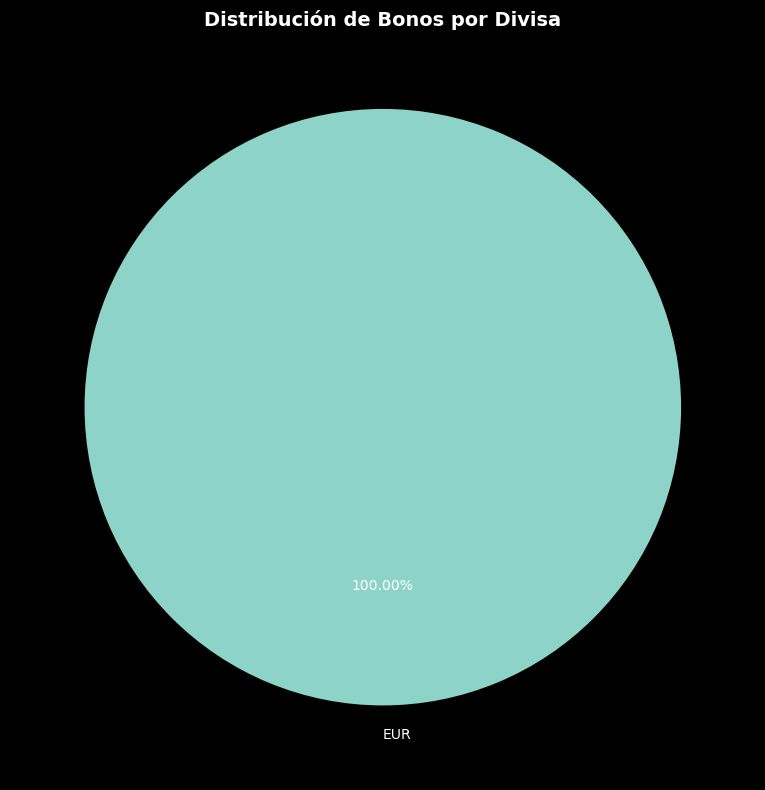

In [19]:

# ANÁLISIS DE DIVISAS:
# Analizamos la distribución de bonos por divisa (moneda)
# Esto es importante porque afecta al riesgo cambiario de la cartera


# Contamos cuántos bonos hay de cada divisa
divisas = universo['Ccy'].value_counts()

print("Distribución de divisas:")
print(divisas)
print(f"\nTotal de divisas diferentes: {len(divisas)}")
print(f"\nPorcentaje por divisa:")
for ccy, count in divisas.items():
    pct = (count / len(universo)) * 100
    print(f"{ccy}: {pct:.2f}%")

# 
# VISUALIZACIÓN DE DIVISAS:
# Creamos un pie chart para visualizar mejor la distribución

# Ajustamos el tamaño a (8, 8) para asegurar que el círculo no se vea ovalado
fig, ax = plt.subplots(figsize=(8, 8))

divisas.plot(
    kind='pie', 
    ax=ax, 
    autopct='%1.2f%%',    # Muestra el porcentaje con 2 decimales
    startangle=90,        # Empieza a rotar desde la parte superior (12 en punto)
    shadow=False,         # (Opcional) Sombra para efecto 3D
    legend=False          # Ocultamos la leyenda si las etiquetas son claras
)

ax.set_ylabel('')  # Eliminamos la etiqueta automática del eje Y que pone pandas
ax.set_title('Distribución de Bonos por Divisa', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

Se puede observar claramente como el 100% de los bonos tienen como divisa el Euro.

#### <font color=#808080>Tipos de bono</font>

In [20]:
# ANÁLISIS DE TIPOS DE BONO:
# Analizamos diferentes características de los bonos que afectan a su
# valoración y riesgo: tipo de cupón, prelación, opcionalidad y perpetuos
#


# 1. TIPO DE CUPÓN (FIJO VS VARIABLE):
# Los bonos pueden tener cupón fijo (tasa constante) o variable (tasa flotante)
# Esto afecta a la sensibilidad a cambios en tipos de interés

tipo_cupon = universo['Coupon Type'].value_counts()
print("Distribución por tipo de cupón:")
print(tipo_cupon)
print(f"\nPorcentaje:")
for tipo, count in tipo_cupon.items():
    pct = (count / len(universo)) * 100
    print(f"{tipo}: {pct:.2f}%")


# 2. PRELACIÓN (SENIORITY):
# La prelación determina el orden de pago en caso de quiebra del emisor
# Senior tiene prioridad sobre Subordinated

prelacion = universo['Seniority'].value_counts()
print(f"\n\nDistribución por prelación:")
print(prelacion)
print(f"\nPorcentaje:")
for sen, count in prelacion.items():
    pct = (count / len(universo)) * 100
    print(f"{sen}: {pct:.2f}%")


# 3. OPCIONALIDAD (CALLABLE):
# Los bonos callable pueden ser recomprados por el emisor antes del vencimiento
# Esto introduce riesgo de reinversión para el inversor

callable_bonds = universo['Callable'].value_counts()
print(f"\n\nBonos con opción de compra (Callable):")
print(callable_bonds)
print(f"\nPorcentaje:")
for call, count in callable_bonds.items():
    pct = (count / len(universo)) * 100
    print(f"{call}: {pct:.2f}%")


# 4. BONOS PERPETUOS (SIN FECHA DE VENCIMIENTO):
# Los bonos perpetuos no tienen fecha de vencimiento fija
# Para valoración, usaremos la próxima fecha call como vencimiento

perpetuos = universo[universo['Maturity'].isna()]
print(f"Bonos perpetuos encontrados: {len(perpetuos)}")


Distribución por tipo de cupón:
Coupon Type
FIXED       1910
VARIABLE     345
Name: count, dtype: int64

Porcentaje:
FIXED: 84.70%
VARIABLE: 15.30%


Distribución por prelación:
Seniority
Sr Unsecured        1675
Sr Non Preferred     190
Sr Preferred         179
Subordinated         153
Jr Subordinated       25
Secured               20
1st lien              13
Name: count, dtype: int64

Porcentaje:
Sr Unsecured: 74.28%
Sr Non Preferred: 8.43%
Sr Preferred: 7.94%
Subordinated: 6.78%
Jr Subordinated: 1.11%
Secured: 0.89%
1st lien: 0.58%


Bonos con opción de compra (Callable):
Callable
Y    1640
N     615
Name: count, dtype: int64

Porcentaje:
Y: 72.73%
N: 27.27%
Bonos perpetuos encontrados: 19


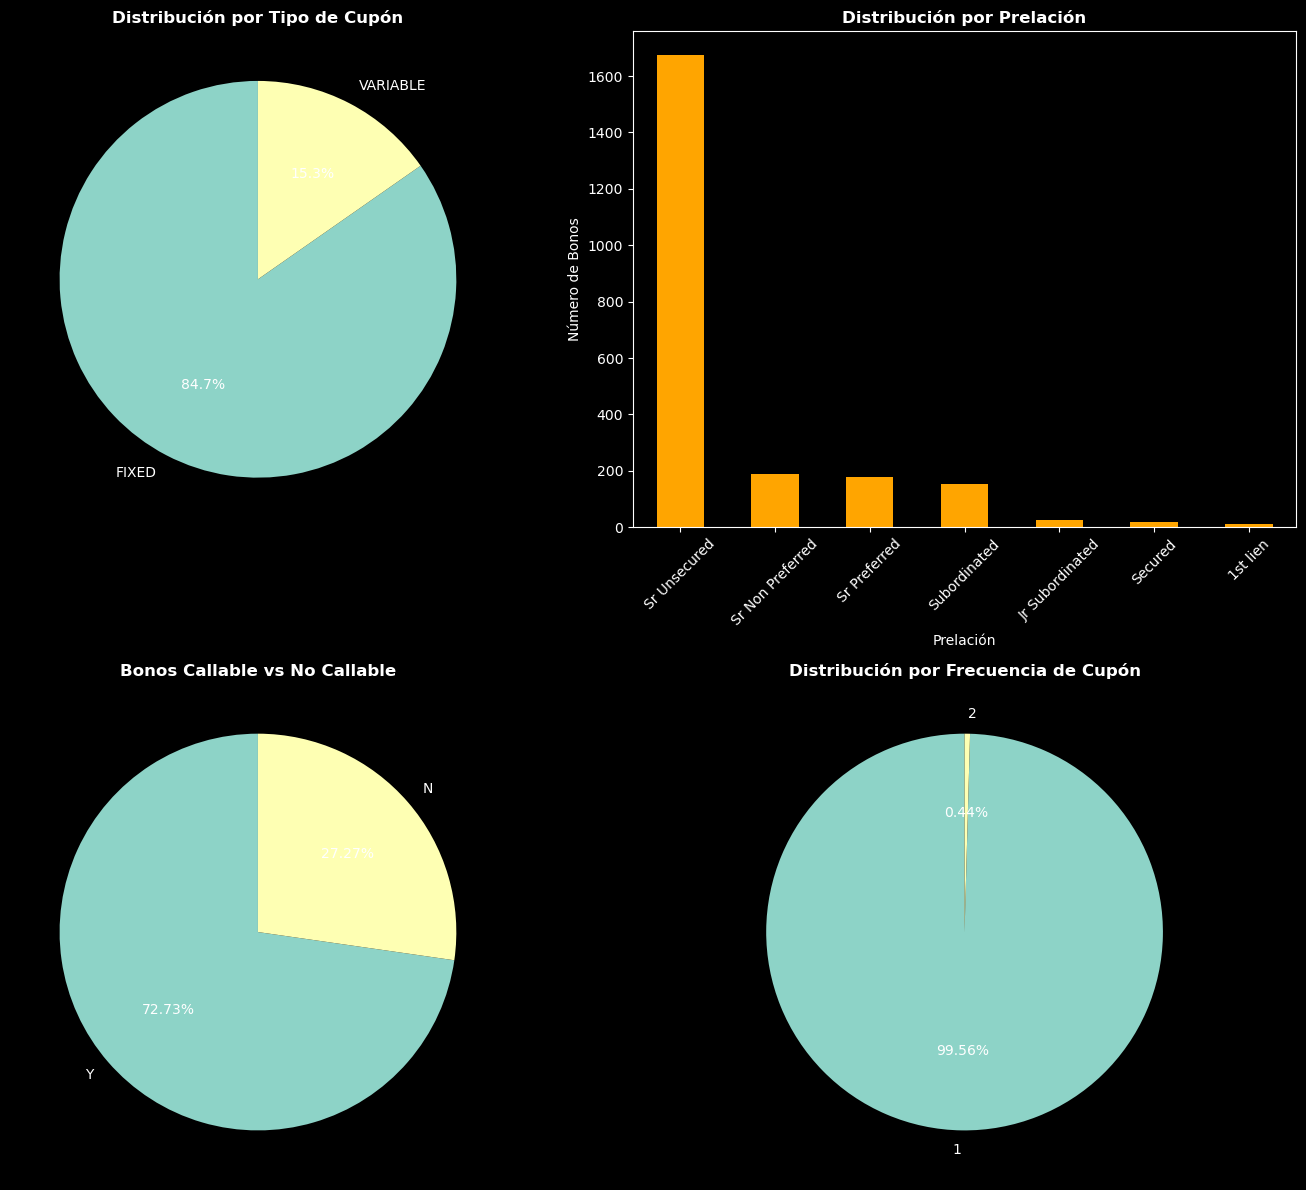

In [21]:
# VISUALIZACIONES DE TIPOS DE BONO:
# Creamos un panel de 4 gráficos para visualizar todas las características
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# --- Gráfico 1: Tipo de cupón ---
tipo_cupon.plot(
    kind='pie', 
    ax=axes[0, 0], 
    autopct='%1.1f%%', 
    startangle=90, 
    ylabel='' # Ocultar etiqueta del eje Y
)
axes[0, 0].set_title('Distribución por Tipo de Cupón', fontsize=12, fontweight='bold')

# --- Gráfico 2: Prelación ---
prelacion.plot(kind='bar', ax=axes[0, 1], color='orange')
axes[0, 1].set_title('Distribución por Prelación', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Prelación')
axes[0, 1].set_ylabel('Número de Bonos')
axes[0, 1].tick_params(axis='x', rotation=45)

# --- Gráfico 3: Callable ---
callable_bonds.plot(
    kind='pie', 
    ax=axes[1, 0], 
    autopct='%1.2f%%', 
    startangle=90, 
    ylabel='',
    

)
axes[1, 0].set_title('Bonos Callable vs No Callable', fontsize=12, fontweight='bold')

# --- Gráfico 4: Frecuencia de cupón ---
freq_cupon = universo['Coupon Frequency'].value_counts()
freq_cupon.plot(
    kind='pie', 
    ax=axes[1, 1], 
    autopct='%1.2f%%', 
    startangle=90, 
    ylabel=''
)
axes[1, 1].set_title('Distribución por Frecuencia de Cupón', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


#### <font color=#808080>Sectores y emisores</font>

Distribución por sectores:
Industry Sector
Financial                 1012
Consumer, Non-cyclical     400
Industrial                 211
Communications             175
Consumer, Cyclical         171
Utilities                  150
Basic Materials             72
Technology                  51
Energy                      13
Name: count, dtype: int64

Total de sectores diferentes: 9


Total de emisores diferentes: 613

Top 10 emisores por número de emisiones:
Issuer
BANQUE FED CRED MUTUEL     33
BNP PARIBAS                27
VONOVIA SE                 23
ORANGE SA                  23
BPCE SA                    23
SOCIETE GENERALE           21
VOLKSWAGEN INTL FIN NV     21
NESTLE FINANCE INTL LTD    20
CREDIT AGRICOLE SA         19
UNIBAIL-RODAMCO-WESTFLD    19
Name: count, dtype: int64


Concentración de los top 10 emisores: 10.16%
Concentración del top emisor: 1.46%


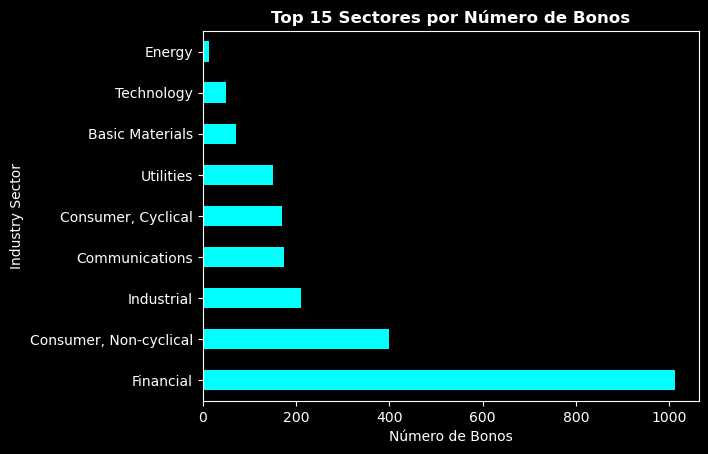

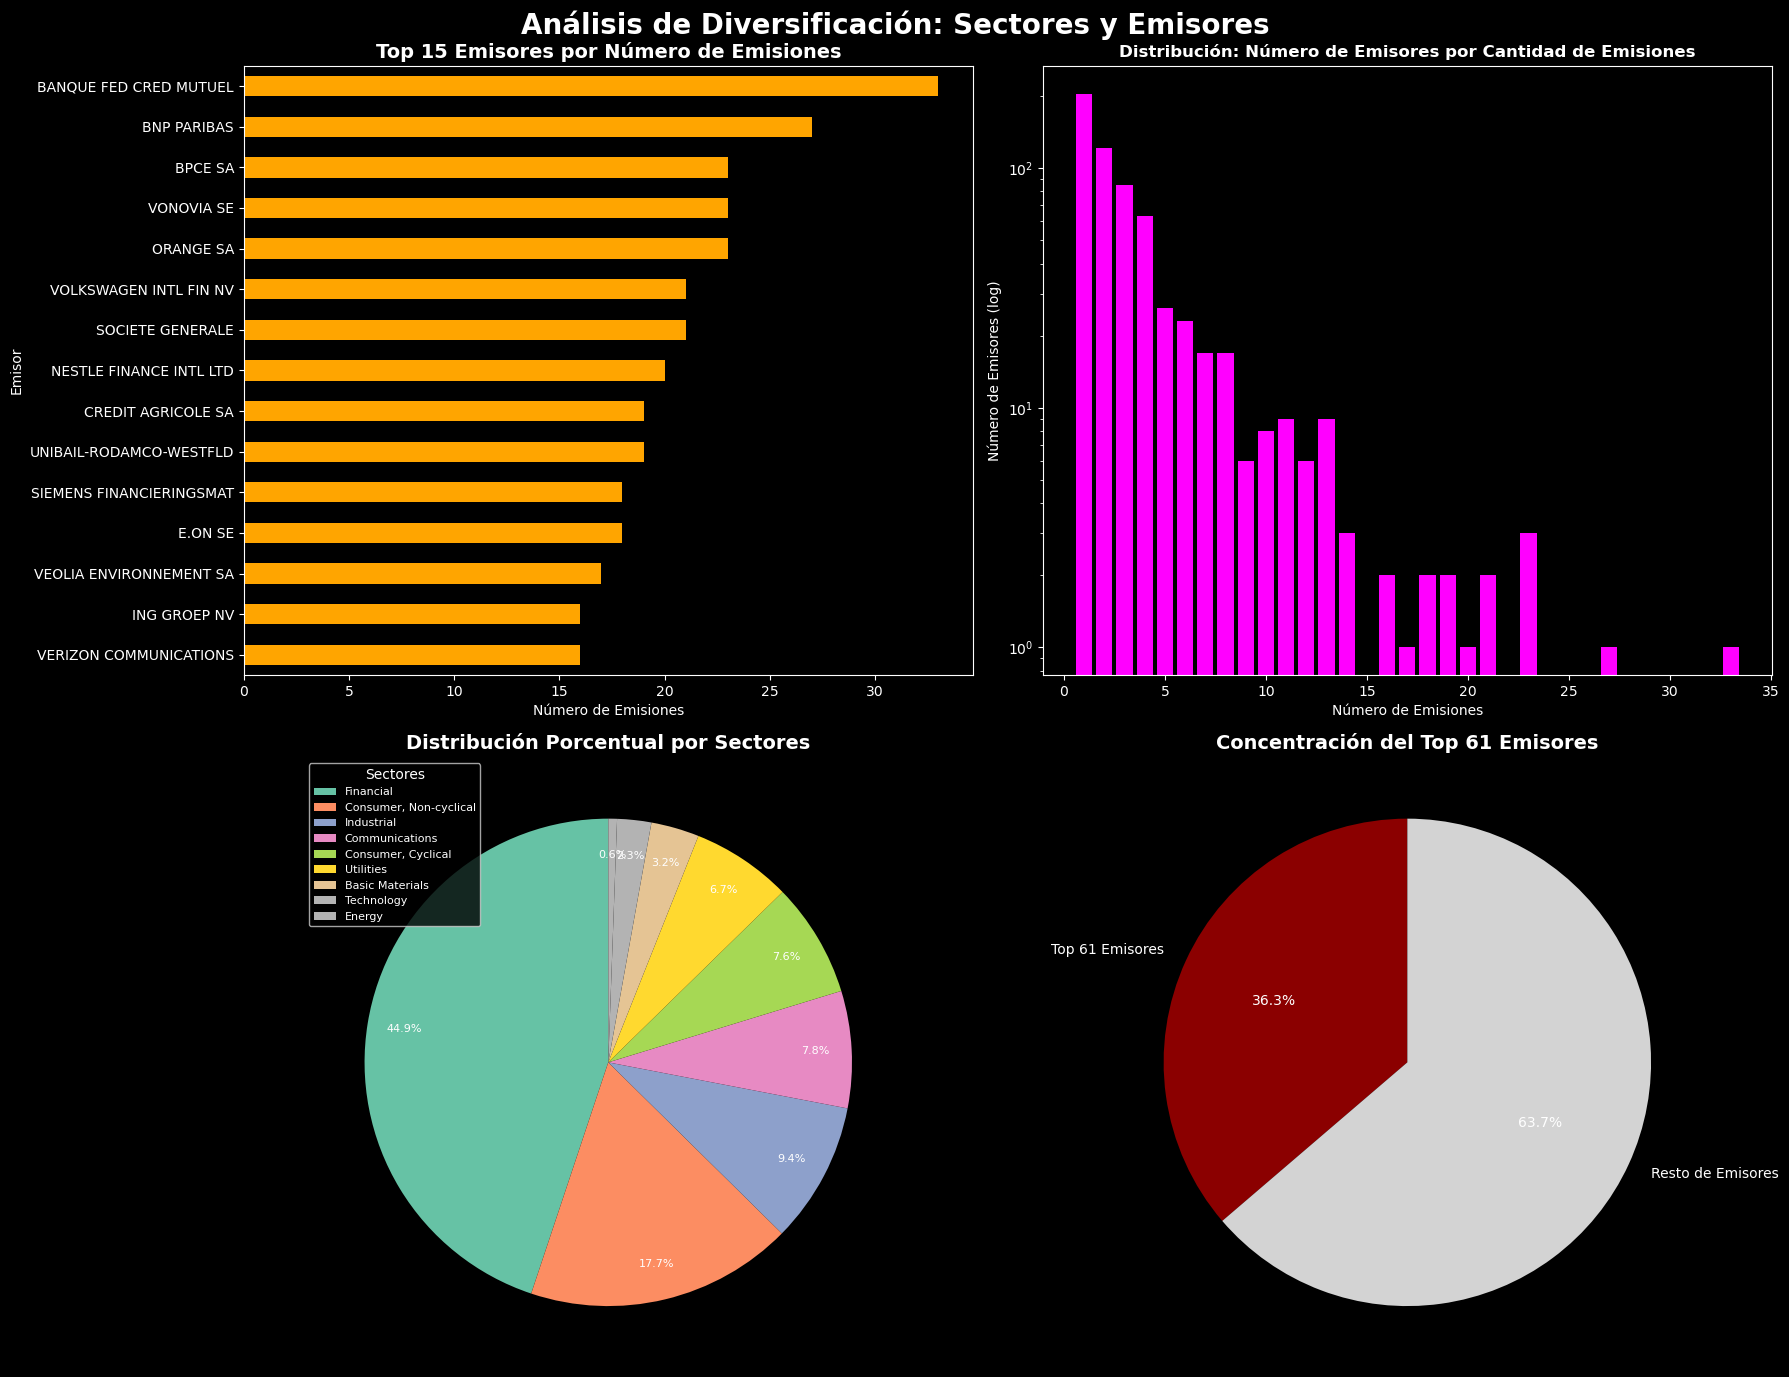


ANÁLISIS DE DIVERSIFICACIÓN DE CARTERA EQUIPONDERADA

1. DIVERSIFICACIÓN HORIZONTAL = EXCELENTE
• 2,255 bonos = riesgo casi eliminado
• 613 emisores con top 1 solo 1.46% = protección contra defaults
• Top 10 emisores: 10.16% = baja concentración por emisor
• Comparable a índices profesionales (iBoxx ~2,500 bonos)

✓ EXCELENTE diversificación horizontal: muchos jugadores (bonos) de diferentes equipos (emisores)

2. DIVERSIFICACIÓN VERTICAL = PREOCUPANTE
• 44.9% en sector financiero vs ~30% en benchmarks (+14.9pp sobreexpuesto)
• HHI sectorial: 2594 (>2,500 = alta concentración)

 RIESGO SISTÉMICO BANCARIO:
   - Bancos interconectados (se prestan entre sí)

• Sectores defensivos bajos: Energy 0.6%, Tech 2.3%, Utilities 6.7%

 PREOCUPANTE diversificación vertical: demasiados juegan en la misma posición (sector financiero)

5. RECOMENDACIONES
• Limitar financiero a ≤30%
• Aumentar defensivos: Energy 5%, Tech 8%, Utilities 10%

CONCLUSIÓN GENERAL:
EXCELENTE diversificación horizontal (bono

In [22]:
# ANÁLISIS DE SECTORES Y EMISORES:
# Analizamos la diversificación de la cartera por sector industrial y emisor
# Una cartera bien diversificada reduce el riesgo de concentración


# 1. DISTRIBUCIÓN POR SECTORES:
# Contamos cuántos bonos hay en cada sector industrial

sectores = universo['Industry Sector'].value_counts()
print("Distribución por sectores:")
print(sectores)
print(f"\nTotal de sectores diferentes: {len(sectores)}")


# 2. DISTRIBUCIÓN POR EMISORES:
# Contamos cuántas emisiones tiene cada emisor
# Esto nos ayuda a identificar concentración por emisor


emisores = universo['Issuer'].value_counts()
print(f"\n\nTotal de emisores diferentes: {len(emisores)}")
print(f"\nTop 10 emisores por número de emisiones:")
print(emisores.head(10))


# 3. ANÁLISIS DE CONCENTRACIÓN:
# Calculamos la concentración de la cartera si fuera equiponderada
# Una alta concentración aumenta el riesgo de la cartera


peso_por_emisor = emisores / len(universo) * 100
concentracion_top10 = peso_por_emisor.head(10).sum()
print(f"\n\nConcentración de los top 10 emisores: {concentracion_top10:.2f}%")
print(f"Concentración del top emisor: {peso_por_emisor.iloc[0]:.2f}%")

# ============================================================================
# VISUALIZACIONES DE SECTORES Y EMISORES
# ============================================================================
# Creamos un panel de 4 gráficos para analizar la diversificación
# ============================================================================


fig= figsize=(16, 12)
# Sectores - Top 15
sectores.head(15).plot(kind='barh', color='cyan')
plt.title('Top 15 Sectores por Número de Bonos', fontsize=12, fontweight='bold')
plt.xlabel('Número de Bonos')


fig, axes = plt.subplots(2, 2, figsize=(18, 14))
plt.suptitle('Análisis de Diversificación: Sectores y Emisores', fontsize=20, fontweight='bold')

# --- 1. Top 15 Emisores (Mantenido - Barras Horizontales) ---
emisores.head(15).sort_values(ascending=True).plot(
    kind='barh', 
    ax=axes[0, 0], 
    color='orange'
)
axes[0, 0].set_title('Top 15 Emisores por Número de Emisiones', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Número de Emisiones')
axes[0, 0].set_ylabel('Emisor')


# Distribución de número de emisiones por emisor
num_emisiones_por_emisor = emisores.value_counts().sort_index()
axes[0, 1].bar(num_emisiones_por_emisor.index, num_emisiones_por_emisor.values, color='magenta')
axes[0, 1].set_title('Distribución: Número de Emisores por Cantidad de Emisiones', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Número de Emisiones')
axes[0, 1].set_ylabel('Número de Emisores (log)')
axes[0, 1].set_yscale('log')

# --- 3. Distribución Porcentual por Sectores (NUEVO - Gráfico Circular) ---
# Ajustamos el gráfico para evitar solapamiento de etiquetas
wedges, texts, autotexts = axes[1, 0].pie(
    sectores.values,
    labels=None,  # No mostramos etiquetas en el gráfico para evitar solapamiento
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.Set2(range(len(sectores))),
    pctdistance=0.85,
    textprops={'fontsize': 8}
)

# Añadimos leyenda fuera del gráfico para evitar solapamiento
axes[1, 0].legend(
    wedges, 
    sectores.index, 
    title="Sectores",
    loc="best",
    fontsize=8,
    frameon=True
)
axes[1, 0].set_title('Distribución Porcentual por Sectores', fontsize=14, fontweight='bold')


# --- 4. Concentración del Top 10% Emisores (NUEVO - Gráfico Circular) ---
# 3. Concentración para el Gráfico Circular
# Calcular el 10% del total de emisores
total_emisores = len(emisores)
num_emisores_top10pct = max(1, round(total_emisores * 0.10))

# Sumar las emisiones del Top 10% de emisores
top_emisores_count = emisores.head(num_emisores_top10pct).sum()
rest_emisores_count = len(universo) - top_emisores_count

# Crear la serie para el gráfico circular de concentración
concentracion_data = pd.Series(
    [top_emisores_count, rest_emisores_count], 
    index=[f'Top {num_emisores_top10pct} Emisores', 'Resto de Emisores']
)
concentracion_data.plot(
    kind='pie', 
    ax=axes[1, 1], 
    autopct='%1.1f%%', 
    startangle=90, 
    ylabel='', 
    colors=['darkred', 'lightgray']
)
axes[1, 1].set_title(f'Concentración del Top {num_emisores_top10pct} Emisores', fontsize=14, fontweight='bold')


plt.tight_layout()
plt.show()

# ============================================================================
# ANÁLISIS DE DIVERSIFICACIÓN HORIZONTAL VS VERTICAL
# ============================================================================
# Calculamos HHI sectorial y porcentajes de distribución
# ============================================================================

# Cálculo de HHI (Herfindahl-Hirschman Index) sectorial
peso_sectorial = sectores / len(universo) * 100
hhi_sectorial = (peso_sectorial ** 2).sum()

# Distribución porcentual por sector
distribucion_sectorial = peso_sectorial.sort_values(ascending=False)
pct_financiero = distribucion_sectorial.get('Financial', 0)
pct_consumer_nc = distribucion_sectorial.get('Consumer, Non-cyclical', 0)
pct_industrial = distribucion_sectorial.get('Industrial', 0)
pct_energy = distribucion_sectorial.get('Energy', 0)
pct_tech = distribucion_sectorial.get('Technology', 0)
pct_utilities = distribucion_sectorial.get('Utilities', 0)

# ============================================================================
# CONCLUSIÓN SOBRE DIVERSIFICACIÓN
# ============================================================================
# Análisis completo de diversificación horizontal (bonos/emisores) 
# vs vertical (sectores)
# ============================================================================

print(f"\n{'='*80}")
print("ANÁLISIS DE DIVERSIFICACIÓN DE CARTERA EQUIPONDERADA")
print(f"{'='*80}")

print(f"\n{'='*80}")
print("1. DIVERSIFICACIÓN HORIZONTAL = EXCELENTE")
print(f"{'='*80}")
print(f"• 2,255 bonos = riesgo casi eliminado")
print(f"• 613 emisores con top 1 solo {peso_por_emisor.iloc[0]:.2f}% = protección contra defaults")
print(f"• Top 10 emisores: {concentracion_top10:.2f}% = baja concentración por emisor")
print(f"• Comparable a índices profesionales (iBoxx ~2,500 bonos)")
print(f"\n✓ EXCELENTE diversificación horizontal: muchos jugadores (bonos) de diferentes equipos (emisores)")

print(f"\n{'='*80}")
print("2. DIVERSIFICACIÓN VERTICAL = PREOCUPANTE")
print(f"{'='*80}")
print(f"• {pct_financiero:.1f}% en sector financiero vs ~30% en benchmarks (+{pct_financiero-30:.1f}pp sobreexpuesto)")
print(f"• HHI sectorial: {hhi_sectorial:.0f} (>2,500 = alta concentración)")
print(f"\n RIESGO SISTÉMICO BANCARIO:")
print(f"   - Bancos interconectados (se prestan entre sí)")
print(f"\n• Sectores defensivos bajos: Energy {pct_energy:.1f}%, Tech {pct_tech:.1f}%, Utilities {pct_utilities:.1f}%")
print(f"\n PREOCUPANTE diversificación vertical: demasiados juegan en la misma posición (sector financiero)")

print(f"\n{'='*80}")
print("5. RECOMENDACIONES")
print(f"{'='*80}")
print("• Limitar financiero a ≤30%")
print("• Aumentar defensivos: Energy 5%, Tech 8%, Utilities 10%")

print(f"\n{'='*80}")
print("CONCLUSIÓN GENERAL:")
print(f"{'='*80}")
print("EXCELENTE diversificación horizontal (bonos/emisores) pero")
print("PREOCUPANTE diversificación vertical (sectores) por alta")
print(f"concentración en financiero ({pct_financiero:.1f}%) y su riesgo sistémico")
print(f"{'='*80}")


Se observa que el 44,9% de los bonos tienen como emisor empresas del sector financiero. Provocando una gran dependencia de este sector y un riesgo sistémico. También cabe notar que hay una cierta diversificación entre los emsisores más numerosos ya que los diez emisores con mas bonos tienen el 10% de la cartera. Al mismo tiempo el top 10% de emisores solo abarca el 36% de los bonos de la cartera.

#### <font color=#808080>Ratings (Riesgo de crédito)</font>

Distribución de ratings:
Rating
A       230
A+      185
A-      374
AA       22
AA+       7
AA-     100
AAA       4
BB+      10
BBB     310
BBB+    439
BBB-    184
NR      389
Name: count, dtype: int64

Total de ratings diferentes: 12

Porcentaje por rating:
A: 10.20%
A+: 8.20%
A-: 16.59%
AA: 0.98%
AA+: 0.31%
AA-: 4.43%
AAA: 0.18%
BB+: 0.44%
BBB: 13.75%
BBB+: 19.47%
BBB-: 8.16%
NR: 17.25%


Clasificación por categoría de riesgo:
Rating_Class
Investment Grade    1855
No Rating            390
High Yield            10
Name: count, dtype: int64

Porcentaje:
Investment Grade: 82.26%
No Rating: 17.29%
High Yield: 0.44%


Análisis de Probabilidad de Default (PD 1YR):
Valores nulos: 24
Estadísticas descriptivas:
count    2.231000e+03
mean     3.616280e-03
std      8.372564e-03
min      2.944640e-12
25%      1.502910e-05
50%      1.253650e-04
75%      1.270443e-03
max      6.312192e-02
Name: PD 1YR, dtype: float64


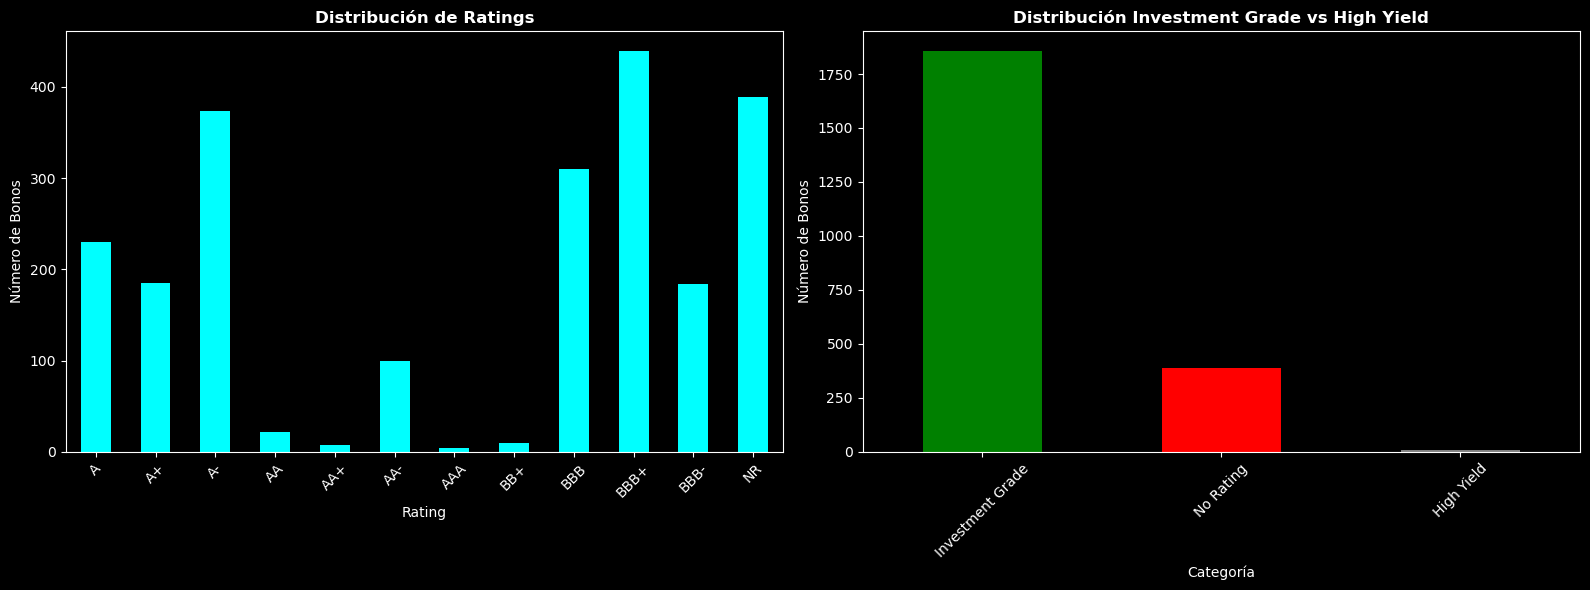

In [23]:
# ANÁLISIS DE RATINGS (RIESGO DE CRÉDITO):
# El rating es una medida clave del riesgo crediticio de cada bono
# Analizamos la distribución de ratings y los clasificamos en categorías

# DISTRIBUCIÓN DE RATINGS:
# Contamos cuántos bonos hay de cada rating específico

ratings = universo['Rating'].value_counts().sort_index()
print("Distribución de ratings:")
print(ratings)
print(f"\nTotal de ratings diferentes: {len(ratings)}")
print(f"\nPorcentaje por rating:")
for rating, count in ratings.items():
    pct = (count / len(universo)) * 100
    print(f"{rating}: {pct:.2f}%")

# CLASIFICACIÓN INVESTMENT GRADE VS HIGH YIELD:
# Definimos las categorías de ratings:
# - Investment Grade: AAA hasta BBB- (menor riesgo crediticio)
# - High Yield: BB+ hasta D (mayor riesgo crediticio)

investment_grade = ['AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+', 'BBB', 'BBB-']
high_yield = ['BB+', 'BB', 'BB-', 'B+', 'B', 'B-', 'CCC+', 'CCC', 'CCC-', 'CC', 'C', 'D']


# FUNCIÓN PARA CLASIFICAR RATINGS:
# Esta función clasifica cada rating en Investment Grade, High Yield o No Rating

def clasificar_rating(rating):
    if pd.isna(rating) or rating == '' or rating == 'NR':
        return 'No Rating'
    rating_clean = str(rating).strip()
    if rating_clean in investment_grade:
        return 'Investment Grade'
    elif rating_clean in high_yield:
        return 'High Yield'
    else:
        return 'No Rating'

# Aplicamos la clasificación a todos los bonos
universo['Rating_Class'] = universo['Rating'].apply(clasificar_rating)
rating_class = universo['Rating_Class'].value_counts()

print(f"\n\nClasificación por categoría de riesgo:")
print(rating_class)
print(f"\nPorcentaje:")
for clase, count in rating_class.items():
    pct = (count / len(universo)) * 100
    print(f"{clase}: {pct:.2f}%")

# ANÁLISIS DE PD (PROBABILIDAD DE DEFAULT A 1 AÑO):
# La PD es una medida cuantitativa del riesgo de impago
# Valores más altos indican mayor probabilidad de default

print(f"\n\nAnálisis de Probabilidad de Default (PD 1YR):")
print(f"Valores nulos: {universo['PD 1YR'].isna().sum()}")
print(f"Estadísticas descriptivas:")
print(universo['PD 1YR'].describe())

# ============================================================================
# VISUALIZACIONES DE RATINGS Y RIESGO DE CRÉDITO
# ============================================================================
# Creamos un panel de 4 gráficos para analizar el riesgo crediticio
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6)) # figsize ajustado para mejor aspecto horizontal

# Distribución de ratings
# Indexación corregida: axes[0]
ratings.plot(kind='bar', ax=axes[0], color='cyan')
axes[0].set_title('Distribución de Ratings', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Número de Bonos')
axes[0].tick_params(axis='x', rotation=45)

# Clasificación IG vs HY
# Indexación corregida: axes[1]
rating_class.plot(kind='bar', ax=axes[1], color=['green', 'red', 'gray'])
axes[1].set_title('Distribución Investment Grade vs High Yield', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Categoría')
axes[1].set_ylabel('Número de Bonos')
axes[1].tick_params(axis='x', rotation=45)

# Ajusta automáticamente el espaciado para que los elementos no se superpongan
plt.tight_layout()

#### <font color=#808080>Riesgo de liquidez - Horquillas y nominal vivo</font>

Análisis de Horquillas (Bid-Ask Spread):
Valores nulos en Bid Price: 0
Valores nulos en Ask Price: 0

Estadísticas del spread absoluto:
count    2255.000000
mean        0.327213
std         0.165488
min         0.064000
25%         0.201000
50%         0.294000
75%         0.418000
max         2.255000
Name: Bid_Ask_Spread, dtype: float64

Estadísticas del spread porcentual:
count    2255.000000
mean        0.346703
std         0.198603
min         0.065484
25%         0.203803
50%         0.301650
75%         0.433251
max         2.521074
Name: Bid_Ask_Spread_Pct, dtype: float64


Análisis de Nominal Vivo (Outstanding Amount):
Valores nulos: 0
Estadísticas descriptivas (en millones):
count    2255.000000
mean      744.928859
std       309.513822
min       249.997000
25%       500.000000
50%       700.000000
75%      1000.000000
max      3000.000000
Name: Outstanding Amount, dtype: float64


Distribución por tamaño de emisión:
Tamaño_Emision
500M - 1B    1549
1B - 2B       556
< 500M  

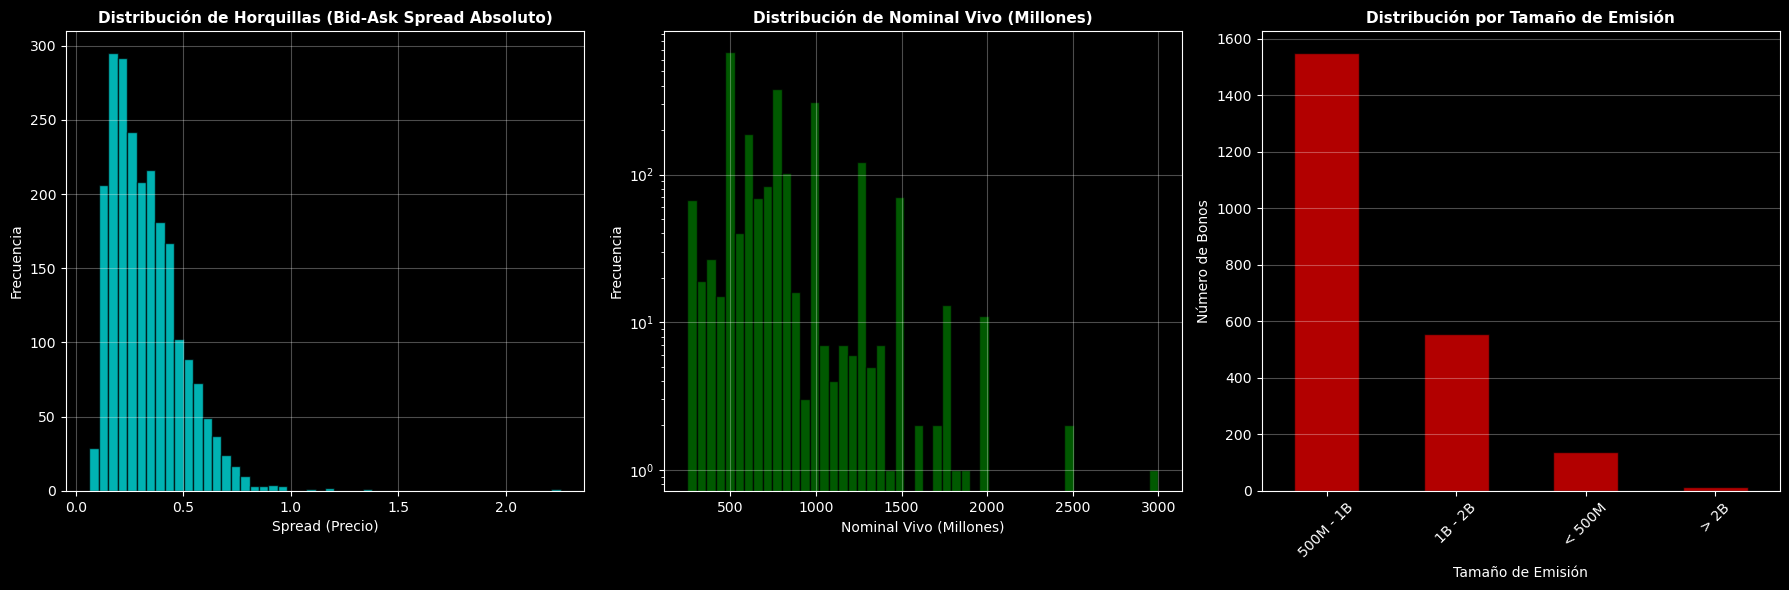


CONCLUSIONES SOBRE RIESGO DE LIQUIDEZ:
- Horquilla media: 0.347%
- Horquilla mediana: 0.302%
- Bonos con horquilla > 1%: 27 (1.20%)
- Bonos con emisión < 500M: 136 (6.03%)
- Bonos con emisión >= 500M: 2119 (93.97%)


In [24]:
# ============================================================================
# ANÁLISIS DE RIESGO DE LIQUIDEZ - HORQUILLAS Y NOMINAL VIVO
# ============================================================================
# El riesgo de liquidez mide la facilidad para comprar/vender un bono
# Analizamos horquillas bid-ask y tamaño de emisión (nominal vivo)
# ============================================================================

# ============================================================================
# 1. CÁLCULO DE HORQUILLAS (BID-ASK SPREAD)
# ============================================================================
# La horquilla es la diferencia entre precio de compra (Ask) y venta (Bid)
# Horquillas más amplias indican menor liquidez
# ============================================================================

universo['Bid_Ask_Spread'] = universo['Ask Price'] - universo['Bid Price']
universo['Bid_Ask_Spread_Pct'] = (universo['Bid_Ask_Spread'] / universo['Price']) * 100

print("Análisis de Horquillas (Bid-Ask Spread):")
print(f"Valores nulos en Bid Price: {universo['Bid Price'].isna().sum()}")
print(f"Valores nulos en Ask Price: {universo['Ask Price'].isna().sum()}")
print(f"\nEstadísticas del spread absoluto:")
print(universo['Bid_Ask_Spread'].describe())
print(f"\nEstadísticas del spread porcentual:")
print(universo['Bid_Ask_Spread_Pct'].describe())

# ============================================================================
# EXPLICACIÓN DE LECTURA DE LAS ESTADÍSTICAS DE SPREAD
# ============================================================================
# 
# SPREAD ABSOLUTO (Bid_Ask_Spread):
# - Representa la diferencia en unidades monetarias (€) entre el precio 
#   de compra (Ask) y el precio de venta (Bid)
# - Ejemplo: Si Ask = 100.50€ y Bid = 100.30€, el spread absoluto = 0.20€
# - Interpretación:
#   * Spread bajo (< 0.30€): Alta liquidez, fácil comprar/vender
#   * Spread medio (0.30-0.50€): Liquidez moderada
#   * Spread alto (> 0.50€): Baja liquidez, mayor coste de transacción
#
# SPREAD PORCENTUAL (Bid_Ask_Spread_Pct):
# - Representa el spread absoluto como porcentaje del precio del bono
# - Fórmula: (Spread Absoluto / Precio del Bono) × 100
# - Ejemplo: Si spread absoluto = 0.20€ y precio = 100€, spread % = 0.20%
# - Interpretación:
#   * Spread < 0.25%: Excelente liquidez (bonos muy líquidos)
#   * Spread 0.25-0.50%: Buena liquidez (bonos estándar)
#   * Spread 0.50-1.00%: Liquidez moderada (riesgo de liquidez medio)
#   * Spread > 1.00%: Baja liquidez (riesgo elevado, difícil salir)
#
# ESTADÍSTICAS DESCRIPTIVAS:
# - count: Número de bonos con datos disponibles
# - mean: Promedio de todos los spreads (tendencia central)
# - std: Desviación estándar (variabilidad: mayor = más dispersión)
# - min/25%/50%/75%/max: Percentiles (25%=Q1, 50%=mediana, 75%=Q3)
#   * Mediana (50%): Valor central, resiste a valores extremos
#   * Q3 (75%): 75% de los bonos tienen spread menor o igual
#
# RELACIÓN SPREAD ABSOLUTO vs PORCENTUAL:
# - El spread absoluto es más útil para comparar bonos con precios similares
# - El spread porcentual permite comparar bonos con diferentes precios
# - Un bono con precio alto puede tener spread absoluto alto pero % bajo
#   (ej: precio 150€, spread 0.45€ = 0.30% → aún buena liquidez)
#
# ============================================================================

# ============================================================================
# 2. ANÁLISIS DE NOMINAL VIVO (OUTSTANDING AMOUNT)
# ============================================================================
# El nominal vivo es el tamaño total de la emisión en circulación
# Emisiones más grandes suelen tener mayor liquidez
# ============================================================================

print(f"\n\nAnálisis de Nominal Vivo (Outstanding Amount):")
print(f"Valores nulos: {universo['Outstanding Amount'].isna().sum()}")
print(f"Estadísticas descriptivas (en millones):")
outstanding_millions = universo['Outstanding Amount'] / 1_000_000
print(outstanding_millions.describe())

# ============================================================================
# CLASIFICACIÓN POR TAMAÑO DE EMISIÓN
# ============================================================================
# Clasificamos las emisiones en categorías según su tamaño
# Esto nos ayuda a identificar bonos con mayor o menor liquidez potencial
# ============================================================================

def clasificar_tamano(nominal):
    if pd.isna(nominal):
        return 'Sin dato'
    nominal_mill = nominal / 1_000_000
    if nominal_mill < 500:
        return '< 500M'
    elif nominal_mill < 1000:
        return '500M - 1B'
    elif nominal_mill < 2000:
        return '1B - 2B'
    else:
        return '> 2B'

universo['Tamaño_Emision'] = universo['Outstanding Amount'].apply(clasificar_tamano)
tamano_dist = universo['Tamaño_Emision'].value_counts()
print(f"\n\nDistribución por tamaño de emisión:")
print(tamano_dist)

# ============================================================================
# RELACIÓN ENTRE HORQUILLA Y TAMAÑO DE EMISIÓN
# ============================================================================
# Analizamos la correlación: emisiones más grandes suelen tener menor horquilla
# ============================================================================

print(f"\n\nCorrelación entre horquilla y tamaño de emisión:")
correlacion = universo[['Bid_Ask_Spread_Pct', 'Outstanding Amount']].corr()
print(correlacion)

# ============================================================================
# VISUALIZACIONES DE RIESGO DE LIQUIDEZ
# ============================================================================
# Creamos un panel de 6 gráficos para analizar la liquidez desde diferentes
# perspectivas
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Histograma de horquillas absolutas
spread_data = universo['Bid_Ask_Spread'].dropna()
axes[0].hist(spread_data, bins=50, color='cyan', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribución de Horquillas (Bid-Ask Spread Absoluto)', fontsize=11, fontweight='bold')
axes[0].set_xlabel('Spread (Precio)')
axes[0].set_ylabel('Frecuencia')
axes[0].grid(True, alpha=0.3)


# Distribución de nominal vivo
outstanding_data = outstanding_millions.dropna()
axes[1].hist(outstanding_data, bins=50, color='green', edgecolor='black', alpha=0.7)
axes[1].set_title('Distribución de Nominal Vivo (Millones)', fontsize=11, fontweight='bold')
axes[1].set_xlabel('Nominal Vivo (Millones)')
axes[1].set_ylabel('Frecuencia')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

# 3. Distribución por tamaño de emisión (CORRECCIÓN AQUÍ)
# Cambiado axes[1, 2] por axes[2]
tamano_dist.plot(kind='bar', ax=axes[2], color='red', edgecolor='black', alpha=0.7)
axes[2].set_title('Distribución por Tamaño de Emisión', fontsize=11, fontweight='bold')
axes[2].set_xlabel('Tamaño de Emisión')
axes[2].set_ylabel('Número de Bonos')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# ============================================================================
# CONCLUSIONES SOBRE RIESGO DE LIQUIDEZ
# ============================================================================
# Resumen de los principales indicadores de liquidez
# ============================================================================

print(f"\n{'='*60}")
print("CONCLUSIONES SOBRE RIESGO DE LIQUIDEZ:")
print(f"{'='*60}")
print(f"- Horquilla media: {universo['Bid_Ask_Spread_Pct'].mean():.3f}%")
print(f"- Horquilla mediana: {universo['Bid_Ask_Spread_Pct'].median():.3f}%")
print(f"- Bonos con horquilla > 1%: {(universo['Bid_Ask_Spread_Pct'] > 1).sum()} ({(universo['Bid_Ask_Spread_Pct'] > 1).sum()/len(universo)*100:.2f}%)")
print(f"- Bonos con emisión < 500M: {(outstanding_millions < 500).sum()} ({(outstanding_millions < 500).sum()/len(universo)*100:.2f}%)")
print(f"- Bonos con emisión >= 500M: {(outstanding_millions >= 500).sum()} ({(outstanding_millions >= 500).sum()/len(universo)*100:.2f}%)")


#### <font color=#808080>Resto de información</font>

En esta sección, analizamos el resto de ficheros para ver qué información tenemos y, en caso de haber *gaps*, limpiar los datos antes de trabajar con ellos.

##### <font color=#CC6600>Precios bonos universo</font>

In [25]:
# El archivo está en '../data/precios_historicos_universo.csv'
file_path = '../data/precios_historicos_universo.csv'

print("ANÁLISIS DE PRECIOS HISTÓRICOS UNIVERSO: ")

# 1. CARGA DE DATOS
# Cargamos el archivo. El índice 0 (la primera columna) contiene los ISINs.
# La primera celda del encabezado está vacía, por lo que es mejor renombrar la columna 0.
precios_universo = pd.read_csv(
    file_path, 
    sep=';', 
    decimal='.', 
    na_values=['#N/D', ' ', 'NA', 'nan', 'N/A']
)

# 2. PREPARACIÓN Y TRANSPOSICIÓN
# Renombramos la primera columna a 'ISIN' y la establecemos como el índice.
precios_df_preparado = precios_universo.rename(
    columns={precios_universo.columns[0]: 'Date'}
).set_index('Date')

# Ejecutamos la Transpuesta (.T)
precios_transpuesto = precios_df_preparado.T


# 3. LIMPIEZA DE FECHAS
# Convertir el nuevo índice (las fechas) a tipo datetime.
precios_transpuesto.index = pd.to_datetime(
    precios_transpuesto.index, 
    format='%d/%m/%Y', 
    errors='coerce' 
)
# 4. Eliminamos la primera fila al ser todos valores nulos y los nulos usamos forward fill
precios_transpuesto = precios_transpuesto.dropna(how='all').ffill(axis=1)

# 5. Mostrar el resultado
print("\n--- Vista Previa del DataFrame Traspuesto ---")
display(precios_transpuesto.head())


ANÁLISIS DE PRECIOS HISTÓRICOS UNIVERSO: 

--- Vista Previa del DataFrame Traspuesto ---


Date,XS0161488498 Corp,FR0000471930 Corp,XS0162513211 Corp,XS0162869076 Corp,FR0010014845 Corp,FR0010033381 Corp,XS0229567440 Corp,XS0300113254 Corp,XS0350890470 Corp,XS0553728709 Corp,...,XS2726335099 Corp,FR001400MDV4 Corp,XS2728560959 Corp,XS2728561098 Corp,XS2729836234 Corp,XS2724401588 Corp,XS2731506841 Corp,FR001400MLN4 Corp,XS2732952838 Corp,XS2694995163 Corp
2023-10-02,126.450,130.386,110.900,112.493,108.291,116.197,97.257,103.831,113.487,103.788,...,100.233,100.233,100.233,100.233,100.233,100.233,100.233,100.233,100.233,100.233
2023-10-03,126.000,129.697,110.567,112.127,107.608,115.831,96.548,103.716,112.907,103.490,...,100.087,100.087,100.087,100.087,100.087,100.087,100.087,100.087,100.087,100.087
2023-10-04,125.939,129.448,110.719,111.844,108.047,115.949,96.548,103.749,113.374,103.024,...,100.200,100.200,100.200,100.200,100.200,100.200,100.200,100.200,100.200,100.200
2023-10-05,126.330,129.795,111.117,112.191,108.480,116.305,97.201,103.907,113.929,103.273,...,100.339,100.339,100.339,100.339,100.339,100.339,100.339,100.339,100.339,100.339
2023-10-06,126.117,129.554,111.036,112.051,108.277,116.173,97.171,103.919,113.891,103.161,...,99.074,99.074,99.074,99.074,99.074,99.074,99.074,99.074,99.074,99.074


Para una mayor facilidad a la hora de trabajar con los datos los hemos traspuesto creando la primera columna 'Date' que  contiene las fechas y luego para cada ISIN los precios a cada una de las fechas, si hay un valor nulo, lo hemos rellenado con el de la fecha anterior.

##### <font color=#CC6600>Otros precios</font>

Para terminar con el análisis de datos, falta lo leído en los ficheros de *"precios_historicos_varios.csv"* y *curvaESTR.csv*.

ANÁLISIS DE OTROS PRECIOS: 

Forma del DataFrame: (514, 7)

 ANÁLISIS DE VALORES NULOS: Precios Varios
Total de filas: 514
Columnas con datos faltantes: 5
------------------------------------------------------------
                            Tipo de Dato  Cantidad Nulos  Porcentaje (%)
ITRX EUR CDSI GEN 5Y Corp        float64               8            1.56
ITRX XOVER CDSI GEN 5Y Corp      float64               8            1.56
DU1 Comdty                       float64               5            0.97
OE1 Comdty                       float64               5            0.97
RX1 Comdty                       float64               5            0.97

Rango de fechas: 2023-10-02 00:00:00 a 2025-10-01 00:00:00
Número de fechas: 514

Instrumentos disponibles:
  - Unnamed: 0
  - ITRX EUR CDSI GEN 5Y Corp
  - ITRX XOVER CDSI GEN 5Y Corp
  - DU1 Comdty
  - OE1 Comdty
  - RX1 Comdty
  - RECMTREU Index
ANÁLISIS DE CURVA ESTR:

Forma del DataFrame: (33, 4)

 ANÁLISIS DE VALORES NULOS: Curva €STER
T

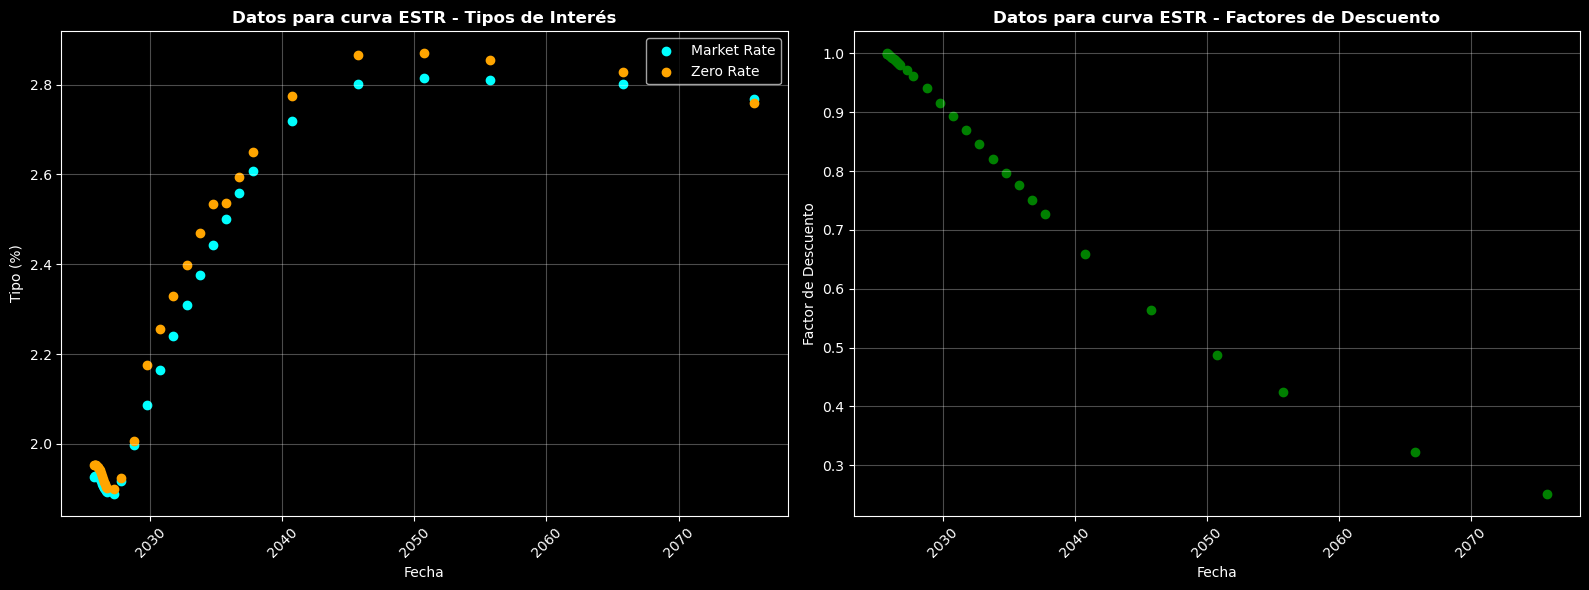

<Figure size 640x480 with 0 Axes>

In [27]:
# Cargar otros precios (futuros, índices de crédito, benchmark)
print("ANÁLISIS DE OTROS PRECIOS: ")
precios_varios = pd.read_csv('../data/precios_historicos_varios.csv', sep=';', decimal='.',na_values=['#N/D', ' ', 'NA', 'nan', 'N/A'])
print(f"\nForma del DataFrame: {precios_varios.shape}")
reportar_gaps_informacion(precios_varios, "Precios Varios")


# Convertir la primera columna (fecha) a datetime
fecha_col = precios_varios.columns[0]
precios_varios[fecha_col] = pd.to_datetime(precios_varios[fecha_col], format='%d/%m/%Y', errors='coerce')
precios_varios_limpios = precios_varios.set_index(fecha_col)

print(f"\nRango de fechas: {precios_varios_limpios.index.min()} a {precios_varios_limpios.index.max()}")
print(f"Número de fechas: {len(precios_varios_limpios)}")

# Separar por tipo de instrumento
print(f"\nInstrumentos disponibles:")
for col in precios_varios.columns:
    print(f"  - {col}")

# Cargar curva ESTR
print("ANÁLISIS DE CURVA ESTR:")

curva_estr = pd.read_csv('../data/curvaESTR.csv', sep=';', decimal='.', na_values=['#N/D', ' ', 'NA', 'nan', 'N/A'])
print(f"\nForma del DataFrame: {curva_estr.shape}")
reportar_gaps_informacion(curva_estr, "Curva €STER")


# Convertir fecha a datetime
curva_estr['Date'] = pd.to_datetime(curva_estr['Date'], format='%d/%m/%Y', errors='coerce')
curva_estr = curva_estr.set_index('Date')

print(f"\nRango de fechas: {curva_estr.index.min()} a {curva_estr.index.max()}")
print(f"\nEstadísticas de la curva:")
print(curva_estr.describe())


# Visualización de la curva
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Curva de tipos (Scatter)
axes[0].scatter(curva_estr.index, curva_estr['Market Rate'], label='Market Rate', color='cyan')
axes[0].scatter(curva_estr.index, curva_estr['Zero Rate'], label='Zero Rate', color='orange')
axes[0].set_title('Datos para curva ESTR - Tipos de Interés', fontweight='bold')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Tipo (%)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Gráfico 2: Factores de descuento (Scatter)
axes[1].scatter(curva_estr.index, curva_estr['Discount'], color='green')
axes[1].set_title('Datos para curva ESTR - Factores de Descuento', fontweight='bold')
axes[1].set_xlabel('Fecha')
axes[1].set_ylabel('Factor de Descuento')
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


plt.tight_layout()
plt.show()


### <font color=#336699>2. Valoración</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 En esta sección, valoraremos los bonos utilizando la curva. Para ello, crea una función (puedes hacerlo en un .py aparte) que con las **características del bono, la curva y un spread de crédito** devuelva la valoración del bono (incluyendo **precio limpio, cupón corrido y precio sucio**).

Si asumimos que el **spread de crédito es 0**, y la ejecutamos para el 01/10/2025...
- ¿Qué observas si comparas los precios obtenidos y los precios de mercado? 
- ¿Crees que la diferencia se debe a un factor relacionado sólo con el riesgo crediticio?
- ¿Qué otros factores influyen en ese spread?

Para la valoración, haz las siguientes simplificaciones:

- Asume que el vencimiento de los bonos perpetuos (para los que no hay vencimiento) es la próxima fecha call.
- Asume que todos aquellos bonos que tengan call serán calleados. Por lo tanto, usa la fecha call como fecha de vencimiento.
- Asume que los cupones son fijos hasta vencimiento (aunque alguno cambie a lo largo de la vida del bono).
- Usa la base de cálculo ACT/365. No tengas en cuenta la convención de día hábil.

Ten en cuenta que necesitarás una función de interpolación también. Interpola los factores de descuento exponencialmente.

</div>

In [ ]:
# Establecemos la fecha
fecha_valor = datetime.datetime(2025,10,1)

VALORACIÓN DE BONOS CON SPREAD = 0

Estadísticas de la diferencia precio mercado vs teórico:
count    2255.000000
mean        5.637135
std         7.367821
min        -5.654044
25%         0.365872
50%         2.998240
75%         8.865065
max        52.321070
Name: Diferencia, dtype: float64


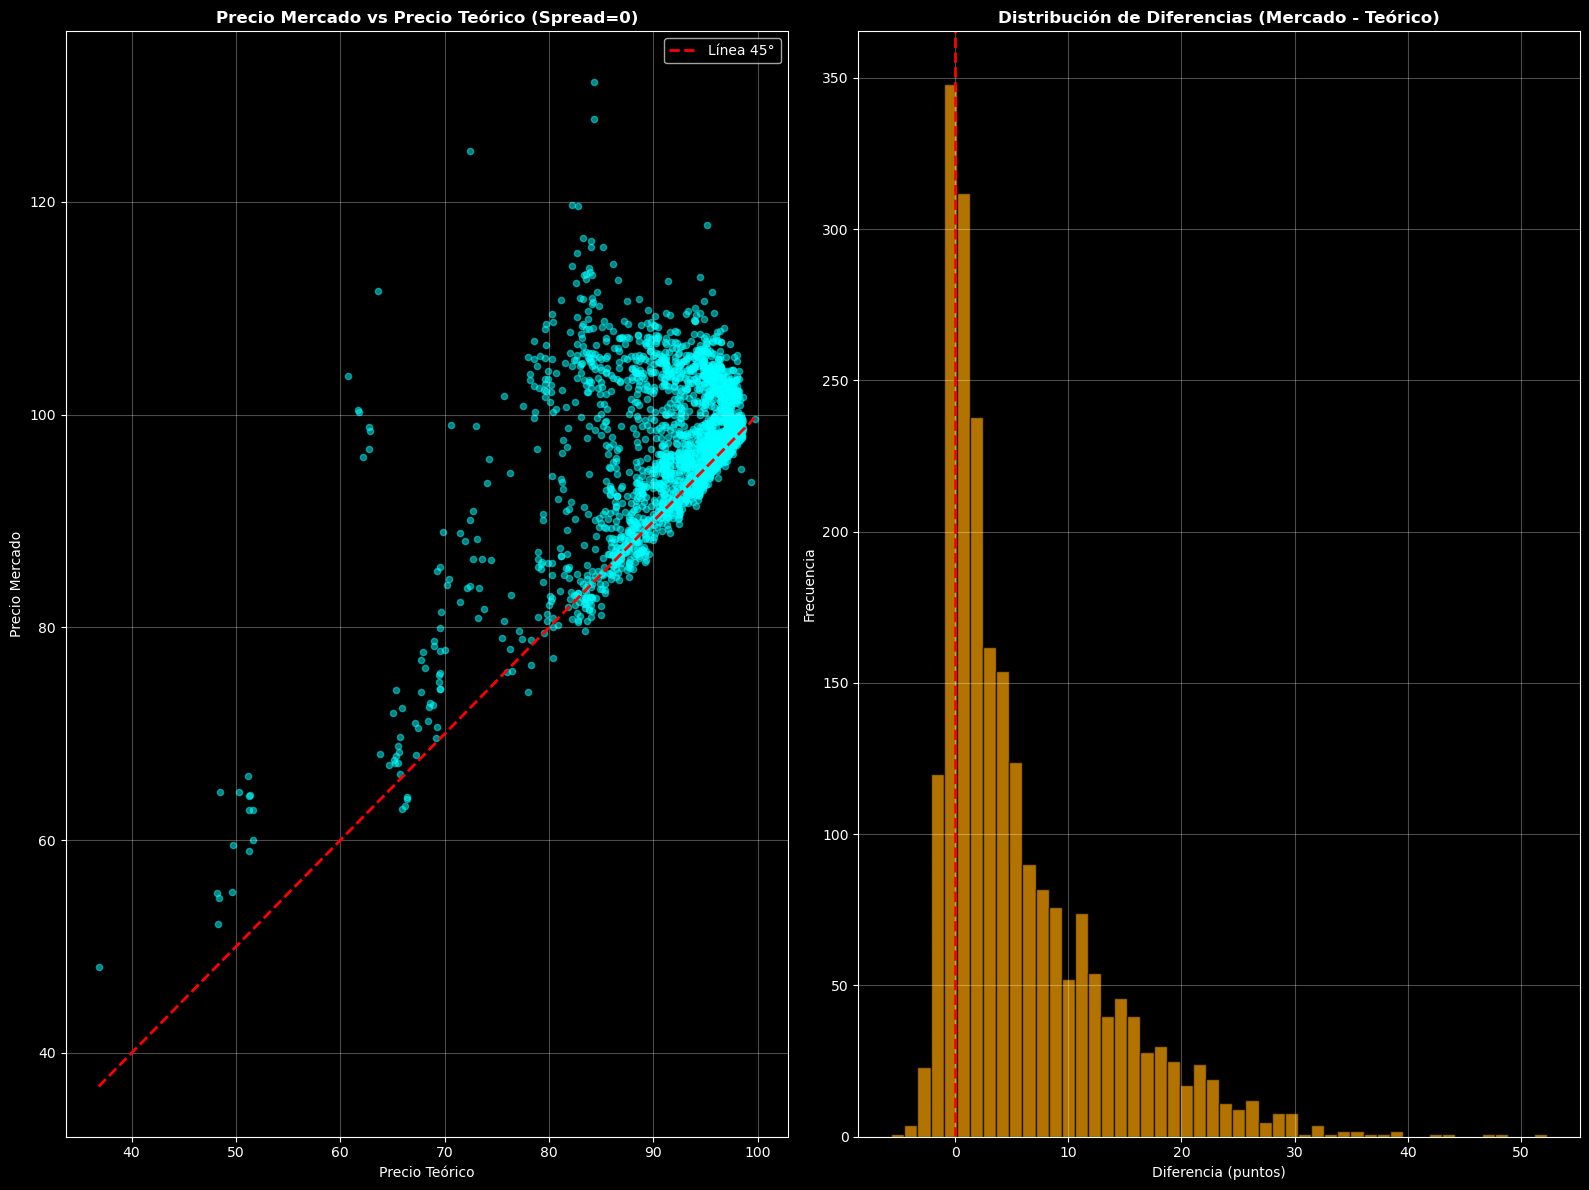


CONCLUSIONES:

1. Si los precios de mercado son sistemáticamente diferentes a los teóricos con spread=0,
   esto indica que los bonos tienen un spread de crédito positivo.

2. Otros factores que influyen en el spread además del riesgo crediticio:
   - Liquidez: bonos menos líquidos tienen spreads más altos
   - Opcionalidad: bonos callable tienen spreads diferentes
   - Tamaño de la emisión: emisiones pequeñas suelen tener spreads más altos
   - Sector/industria: algunos sectores tienen spreads estructuralmente más altos
   - Convenciones de mercado y factores técnicos



In [ ]:
def interpolate_discount_factor(curva, fecha_valor, fecha_pago):
    """
    Interpola el factor de descuento exponencialmente para una fecha dada.
    
    La interpolación exponencial se realiza en el espacio logarítmico:
    log(DF(t)) = a + b*t, donde DF(t) es el factor de descuento al tiempo t.
    
    Parámetros:
    - curva: DataFrame con índice de fechas y columna 'Discount'
    - fecha_valor: fecha de valoración
    - fecha_pago: fecha del pago a descontar
    
    Retorna:
    - factor de descuento interpolado
    """
    # Calcular días desde fecha valor
    dias_valor = (fecha_pago - fecha_valor).days
    
    if dias_valor <= 0:
        return 1.0
    
    # Obtener fechas y factores de descuento de la curva
    # Eliminar valores nulos y ordenar por fecha
    curva_clean = curva.dropna(subset=['Discount']).sort_index()
    fechas_curva = curva_clean.index
    factores_curva = curva_clean['Discount'].values
    
    if len(fechas_curva) == 0:
        raise ValueError("La curva no contiene datos válidos")
    
    # Convertir días a fracción de año (ACT/365)
    años_curva = np.array([(fecha - fecha_valor).days / 365.0 for fecha in fechas_curva])
    años_pago = dias_valor / 365.0
    
    # Interpolación logarítmica (exponencial)
    # log(DF) = a + b*t
    log_factores = np.log(factores_curva)
    
    # Interpolación lineal en el espacio logarítmico
    if años_pago <= años_curva[0]:
        # Extrapolación hacia atrás: usar el primer punto
        # Asumimos tasa constante desde el primer punto
        if años_curva[0] > 0:
            tasa_impl = -np.log(factores_curva[0]) / años_curva[0]
            return np.exp(-tasa_impl * años_pago)
        else:
            return 1.0
    elif años_pago >= años_curva[-1]:
        # Extrapolación hacia adelante: usar el último punto
        # Asumimos tasa constante desde el último punto
        if años_curva[-1] > 0:
            tasa_impl = -np.log(factores_curva[-1]) / años_curva[-1]
            return np.exp(-tasa_impl * años_pago)
        else:
            return factores_curva[-1]
    else:
        # Interpolación entre puntos
        f_interp = interpolate.interp1d(años_curva, log_factores, kind='linear', 
                                        fill_value='extrapolate', bounds_error=False)
        log_df = f_interp(años_pago)
        return np.exp(log_df)


def valorar_bono(bono, curva, fecha_valor, spread_credito=0):
    """
    Valora un bono utilizando la curva de descuento y un spread de crédito.
    
    Parámetros:
    - bono: Serie de pandas con las características del bono
    - curva: DataFrame con la curva de descuento
    - fecha_valor: fecha de valoración (datetime)
    - spread_credito: spread de crédito en puntos básicos (default: 0)
    
    Retorna:
    - diccionario con precio_limpio, cupon_corrido, precio_sucio
    """
    # Determinar fecha de vencimiento
    # Si es callable, usar fecha call; si es perpetuo, usar próxima fecha call
    if pd.notna(bono['Next Call Date']):
        fecha_vencimiento = bono['Next Call Date']
    elif pd.isna(bono['Maturity']):
        # Perpetuo sin call date - usar fecha call si existe
        if pd.notna(bono['Next Call Date']):
            fecha_vencimiento = bono['Next Call Date']
        else:
            raise ValueError("Bono perpetuo sin fecha call")
    else:
        fecha_vencimiento = bono['Maturity']
    
    # Cupón y frecuencia
    cupon = bono['Coupon'] / 100.0  # Convertir a decimal
    freq_cupon = bono['Coupon Frequency']  # Pagos por año
    
    # Fechas de cupón
    fecha_primer_cupon = bono['First Coupon Date']
    fecha_penultimo_cupon = bono['Penultimate Coupon Date']
    
    # Generar todas las fechas de cupón
    fechas_cupon = []
    fecha_actual = fecha_primer_cupon
    
    while fecha_actual <= fecha_vencimiento:
        fechas_cupon.append(fecha_actual)
        # Calcular siguiente fecha de cupón (aproximadamente)
        if freq_cupon == 1:
            fecha_actual = fecha_actual + pd.DateOffset(years=1)
        elif freq_cupon == 2:
            fecha_actual = fecha_actual + pd.DateOffset(months=6)
        elif freq_cupon == 4:
            fecha_actual = fecha_actual + pd.DateOffset(months=3)
        else:
            fecha_actual = fecha_actual + pd.DateOffset(months=12/freq_cupon)
    
    # Si la última fecha no coincide exactamente con vencimiento, ajustar
    if fechas_cupon[-1] != fecha_vencimiento:
        fechas_cupon[-1] = fecha_vencimiento
    
    # Filtrar fechas de cupón futuras
    fechas_cupon = [f for f in fechas_cupon if f > fecha_valor]
    
    # Calcular valor presente de los cupones
    vp_cupones = 0
    for fecha_cupon in fechas_cupon[:-1]:  # Todos excepto el último
        dias = (fecha_cupon - fecha_valor).days
        if dias > 0:
            df = interpolate_discount_factor(curva, fecha_valor, fecha_cupon)
            # Ajustar por spread de crédito
            df_ajustado = df * np.exp(-spread_credito / 10000 * dias / 365.0)
            vp_cupones += (cupon / freq_cupon) * df_ajustado
    
    # Valor presente del último cupón + principal
    fecha_ultimo = fechas_cupon[-1]
    dias_ultimo = (fecha_ultimo - fecha_valor).days
    if dias_ultimo > 0:
        df_ultimo = interpolate_discount_factor(curva, fecha_valor, fecha_ultimo)
        df_ultimo_ajustado = df_ultimo * np.exp(-spread_credito / 10000 * dias_ultimo / 365.0)
        vp_principal = 100 * df_ultimo_ajustado  # Principal = 100
        vp_ultimo_cupon = (cupon / freq_cupon) * df_ultimo_ajustado
    else:
        vp_principal = 100
        vp_ultimo_cupon = 0
    
    precio_limpio = vp_cupones + vp_ultimo_cupon + vp_principal
    
    # Calcular cupón corrido
    # Encontrar fecha de cupón anterior
    fecha_cupon_anterior = None
    fecha_temp = fecha_primer_cupon
    while fecha_temp < fecha_valor:
        fecha_cupon_anterior = fecha_temp
        if freq_cupon == 1:
            fecha_temp = fecha_temp + pd.DateOffset(years=1)
        elif freq_cupon == 2:
            fecha_temp = fecha_temp + pd.DateOffset(months=6)
        elif freq_cupon == 4:
            fecha_temp = fecha_temp + pd.DateOffset(months=3)
        else:
            fecha_temp = fecha_temp + pd.DateOffset(months=12/freq_cupon)
    
    if fecha_cupon_anterior is not None:
        dias_desde_cupon = (fecha_valor - fecha_cupon_anterior).days
        dias_periodo = (fecha_temp - fecha_cupon_anterior).days
        cupon_corrido = (cupon / freq_cupon) * (dias_desde_cupon / dias_periodo)
    else:
        cupon_corrido = 0
    
    precio_sucio = precio_limpio + cupon_corrido
    
    return {
        'precio_limpio': precio_limpio,
        'cupon_corrido': cupon_corrido,
        'precio_sucio': precio_sucio
    }


# Obtener curva para la fecha de análisis
# La curva ESTR contiene fechas de vencimiento (futuras), no fechas históricas
# Por lo tanto, usamos toda la curva disponible
fecha_analisis_dt = pd.to_datetime(fecha_analisis)
curva_fecha = curva_estr.copy()  # Usar toda la curva, ya que son fechas de vencimiento

# Valorar todos los bonos con spread = 0
print("=" * 80)
print("VALORACIÓN DE BONOS CON SPREAD = 0")
print("=" * 80)

resultados_valoracion = []
for idx, bono in universo.iterrows():
    try:
        valoracion = valorar_bono(bono, curva_fecha, fecha_analisis_dt, spread_credito=0)
        resultados_valoracion.append({
            'ISIN': bono['ISIN'],
            'Precio_Mercado': bono['Price'],
            'Precio_Teorico': valoracion['precio_limpio'],
            'Diferencia': bono['Price'] - valoracion['precio_limpio'],
        })
    except Exception as e:
        print(f"Error valorando {bono['ISIN']}: {e}")

df_valoracion = pd.DataFrame(resultados_valoracion)

print(f"\nEstadísticas de la diferencia precio mercado vs teórico:")
print(df_valoracion['Diferencia'].describe())

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(16, 12))

# Scatter: Precio mercado vs teórico
axes[0].scatter(df_valoracion['Precio_Teorico'], df_valoracion['Precio_Mercado'], 
                   alpha=0.5, color='cyan', s=20)
axes[0].plot([df_valoracion['Precio_Teorico'].min(), df_valoracion['Precio_Teorico'].max()],
                [df_valoracion['Precio_Teorico'].min(), df_valoracion['Precio_Teorico'].max()],
                'r--', linewidth=2, label='Línea 45°')
axes[0].set_title('Precio Mercado vs Precio Teórico (Spread=0)', fontweight='bold')
axes[0].set_xlabel('Precio Teórico')
axes[0].set_ylabel('Precio Mercado')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Histograma de diferencias
axes[1].hist(df_valoracion['Diferencia'], bins=50, color='orange', edgecolor='black', alpha=0.7)
axes[1].set_title('Distribución de Diferencias (Mercado - Teórico)', fontweight='bold')
axes[1].set_xlabel('Diferencia (puntos)')
axes[1].set_ylabel('Frecuencia')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1].grid(True, alpha=0.3)


plt.tight_layout()
plt.show()



1. Si los precios de mercado son sistemáticamente diferentes a los teóricos con spread=0,
   esto indica que los bonos tienen un spread de crédito positivo.

2. Otros factores que influyen en el spread además del riesgo crediticio:
   - Liquidez: bonos menos líquidos tienen spreads más altos
   - Opcionalidad: bonos callable tienen spreads diferentes
   - Tamaño de la emisión: emisiones pequeñas suelen tener spreads más altos
   - Sector/industria: algunos sectores tienen spreads estructuralmente más altos
   - Convenciones de mercado y factores técnicos

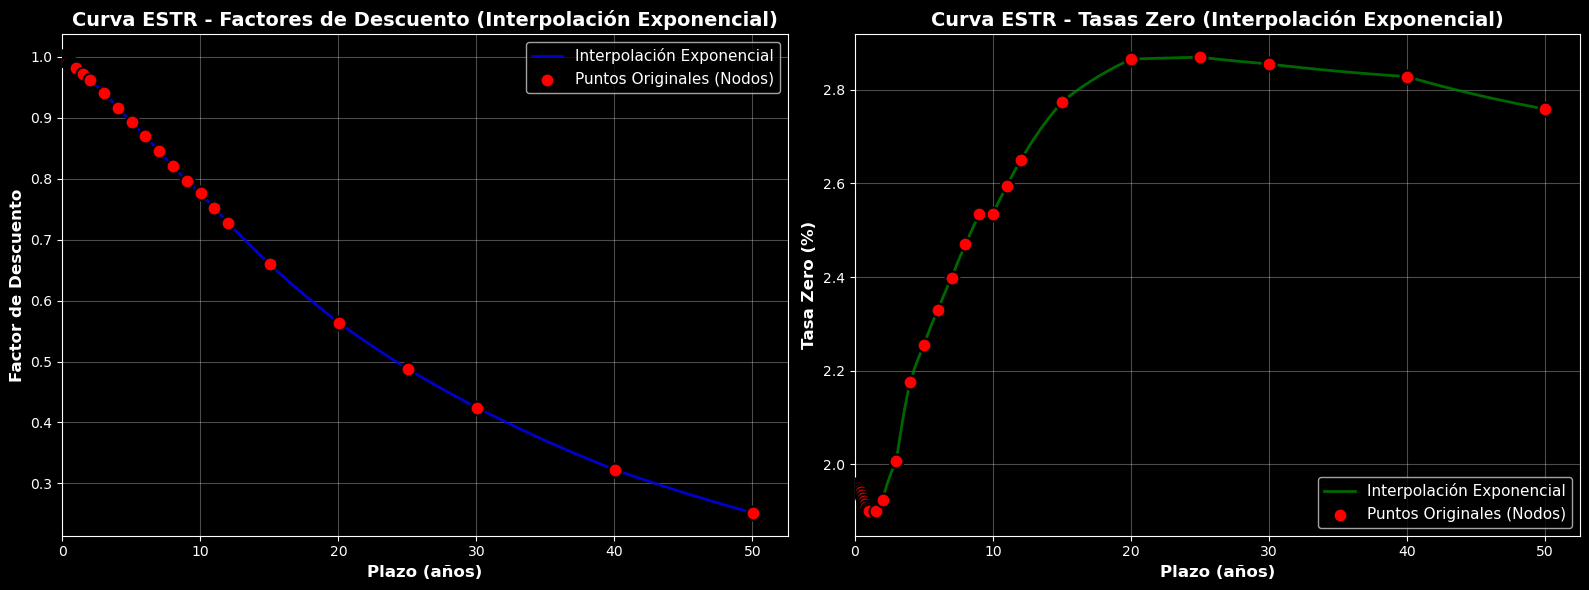

INFORMACIÓN DE LA CURVA ESTR - INTERPOLACIÓN EXPONENCIAL

Fecha de valoración: 01/10/2025
Número de nodos originales: 32
Plazo mínimo: 0.02 años (9 días)
Plazo máximo: 50.04 años (18264 días)

Factores de descuento:
  Mínimo: 0.251512
  Máximo: 0.999518

Tasas zero (%):
  Mínima: 1.9006%
  Máxima: 2.8694%
  Media: 2.2435%

Método de interpolación: Exponencial (log-lineal)
  - Se interpola log(DF) linealmente en función del tiempo
  - Esto garantiza que la curva de tasas sea continua y suave


In [ ]:
def visualizar_curva_interpolada(curva, fecha_valor):
    """
    Visualiza la curva de descuento original y la interpolada exponencialmente.
    
    Parámetros:
    - curva: DataFrame con índice de fechas y columna 'Discount'
    - fecha_valor: fecha de valoración
    """
    # Limpiar y ordenar la curva
    curva_clean = curva.dropna(subset=['Discount']).sort_index()
    fechas_curva = curva_clean.index
    factores_curva = curva_clean['Discount'].values
    
    # Calcular años desde fecha de valoración
    años_curva = np.array([(fecha - fecha_valor).days / 365.0 for fecha in fechas_curva])
    
    # Filtrar solo valores positivos de años
    mask = años_curva > 0
    años_curva = años_curva[mask]
    factores_curva = factores_curva[mask]
    fechas_curva = fechas_curva[mask]
    
    if len(años_curva) == 0:
        print("No hay puntos válidos en la curva para visualizar")
        return
    
    # Generar puntos interpolados (más densos para suavizar la curva)
    años_interpolados = np.linspace(max(0.01, años_curva[0]), años_curva[-1], 500)
    factores_interpolados = []
    
    for año in años_interpolados:
        fecha_pago = fecha_valor + pd.Timedelta(days=int(año * 365))
        df = interpolate_discount_factor(curva_clean, fecha_valor, fecha_pago)
        factores_interpolados.append(df)
    
    factores_interpolados = np.array(factores_interpolados)
    
    # Crear la visualización
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Gráfico 1: Factores de descuento con interpolación exponencial
    axes[0].plot(años_interpolados, factores_interpolados, 'b-', linewidth=2, 
                 label='Interpolación Exponencial', alpha=0.8)
    axes[0].scatter(años_curva, factores_curva, color='red', s=100, 
                    label='Puntos Originales (Nodos)', zorder=5, edgecolor='black', linewidth=1.5)
    axes[0].set_xlabel('Plazo (años)', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Factor de Descuento', fontsize=12, fontweight='bold')
    axes[0].set_title('Curva ESTR - Factores de Descuento (Interpolación Exponencial)', 
                     fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlim(left=0)
    
    # Gráfico 2: Tasas implícitas (Zero Rates) con interpolación exponencial
    # Calcular tasas zero: r = -ln(DF)/T
    # Evitar división por cero
    mask_tasas = años_interpolados > 0
    tasas_interpoladas = np.zeros_like(años_interpolados)
    tasas_interpoladas[mask_tasas] = -np.log(factores_interpolados[mask_tasas]) / años_interpolados[mask_tasas] * 100
    
    mask_tasas_orig = años_curva > 0
    tasas_originales = np.zeros_like(años_curva)
    tasas_originales[mask_tasas_orig] = -np.log(factores_curva[mask_tasas_orig]) / años_curva[mask_tasas_orig] * 100
    
    axes[1].plot(años_interpolados[mask_tasas], tasas_interpoladas[mask_tasas], 'g-', linewidth=2, 
                 label='Interpolación Exponencial', alpha=0.8)
    axes[1].scatter(años_curva[mask_tasas_orig], tasas_originales[mask_tasas_orig], color='red', s=100, 
                    label='Puntos Originales (Nodos)', zorder=5, edgecolor='black', linewidth=1.5)
    axes[1].set_xlabel('Plazo (años)', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Tasa Zero (%)', fontsize=12, fontweight='bold')
    axes[1].set_title('Curva ESTR - Tasas Zero (Interpolación Exponencial)', 
                     fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xlim(left=0)
    
    plt.tight_layout()
    plt.show()
    
    # Imprimir información sobre la curva
    print("=" * 80)
    print("INFORMACIÓN DE LA CURVA ESTR - INTERPOLACIÓN EXPONENCIAL")
    print("=" * 80)
    print(f"\nFecha de valoración: {fecha_valor.strftime('%d/%m/%Y')}")
    print(f"Número de nodos originales: {len(años_curva)}")
    print(f"Plazo mínimo: {años_curva[0]:.2f} años ({años_curva[0]*365:.0f} días)")
    print(f"Plazo máximo: {años_curva[-1]:.2f} años ({años_curva[-1]*365:.0f} días)")
    print(f"\nFactores de descuento:")
    print(f"  Mínimo: {factores_curva.min():.6f}")
    print(f"  Máximo: {factores_curva.max():.6f}")
    print(f"\nTasas zero (%):")
    tasas_validas = tasas_originales[mask_tasas_orig]
    if len(tasas_validas) > 0:
        print(f"  Mínima: {tasas_validas.min():.4f}%")
        print(f"  Máxima: {tasas_validas.max():.4f}%")
        print(f"  Media: {tasas_validas.mean():.4f}%")
    print(f"\nMétodo de interpolación: Exponencial (log-lineal)")
    print(f"  - Se interpola log(DF) linealmente en función del tiempo")
    print(f"  - Esto garantiza que la curva de tasas sea continua y suave")
    print("=" * 80)

# Visualizar la curva con interpolación exponencial
visualizar_curva_interpolada(curva_fecha, fecha_analisis_dt)

### <font color=#336699>3. Spread</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Calculemos ahora los spreads que debemos añadir a la curva con un movimiento paralelo para que cuadren los precios de mercado que tenemos. Para ello, usa la función de valoración del apartado anterior. 
- ¿Qué observas? ¿Tienen sentido los resultados? 
- ¿Con qué datos de los que tenemos compararías para ver si los resultados son coherentes?

</div>

CÁLCULO DE SPREADS DE CRÉDITO

Bonos procesados: 2255

Estadísticas de spreads:
count    2255.000000
mean     -142.537382
std       156.263275
min      -803.364565
25%      -283.056359
50%       -98.974101
75%       -12.969200
max      1608.712027
Name: Spread_bp, dtype: float64


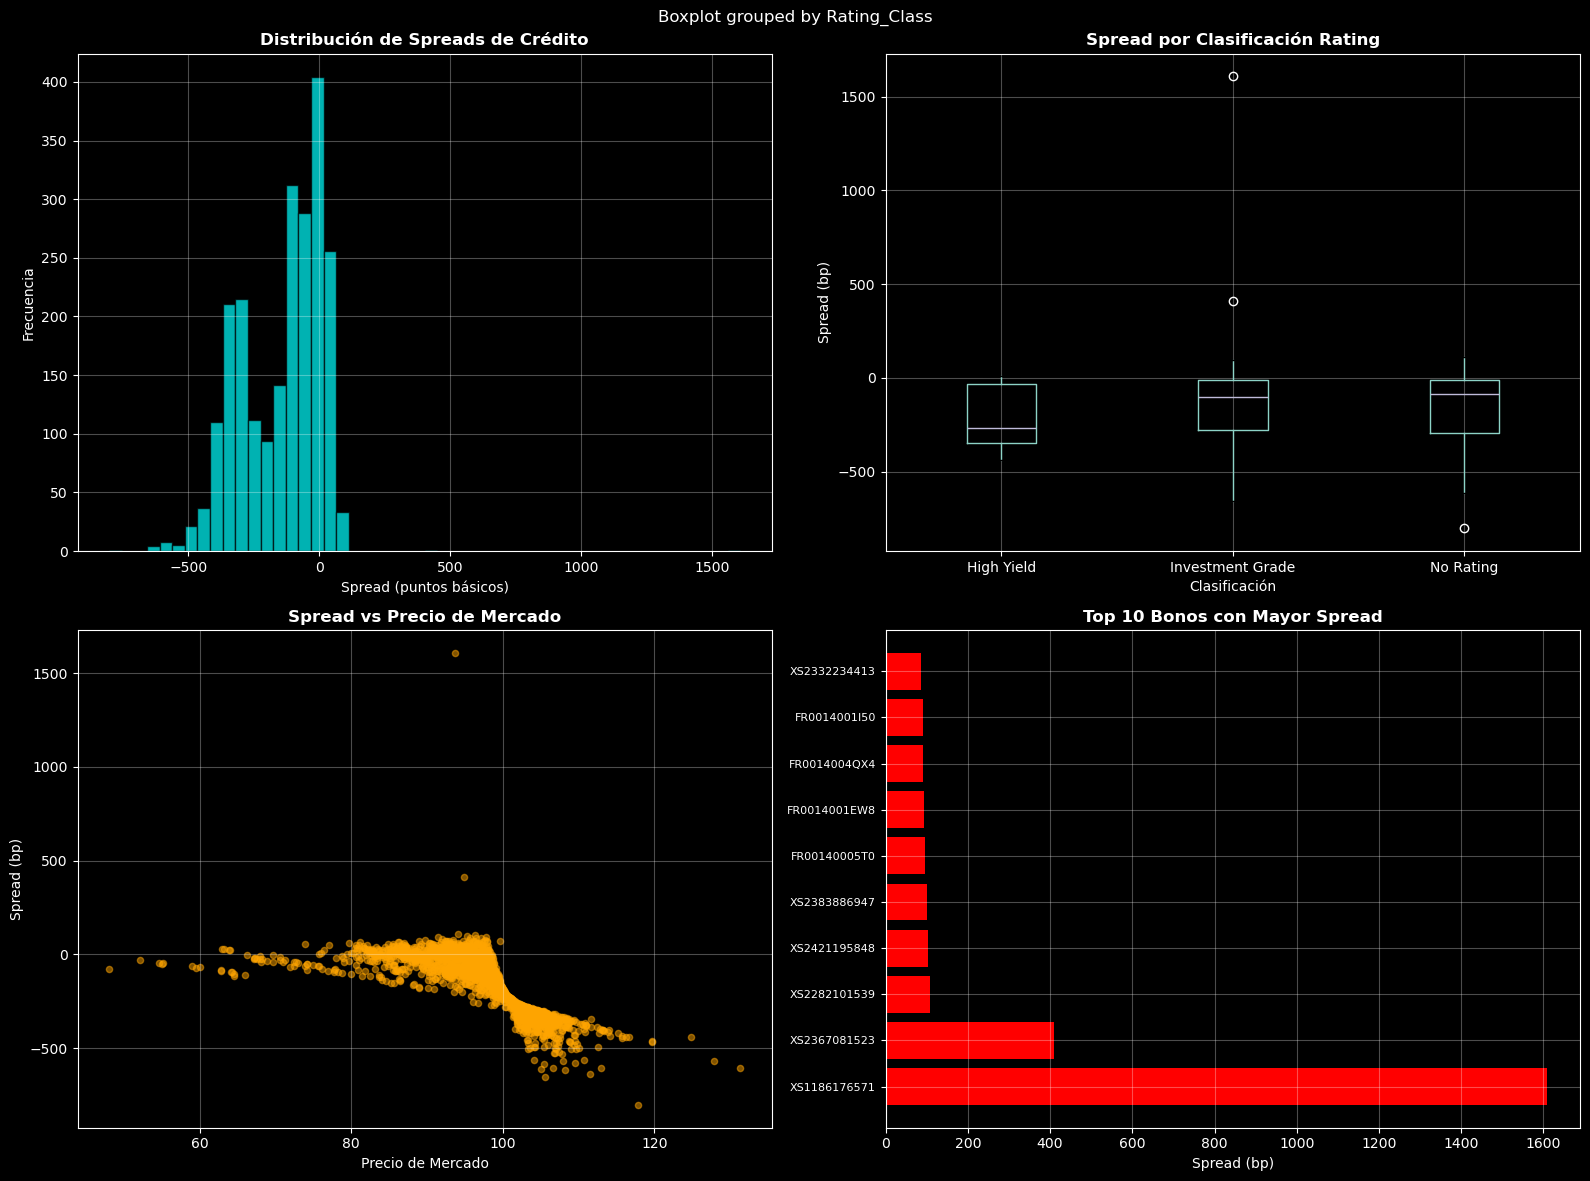


CONCLUSIONES:

1. Los spreads calculados representan la compensación por riesgo crediticio
   que el mercado exige sobre la curva libre de riesgo.

2. Factores que influyen en el spread además del riesgo crediticio:
   - Liquidez: bonos menos líquidos tienen spreads más altos
   - Opcionalidad: bonos callable tienen spreads diferentes
   - Tamaño de emisión: emisiones pequeñas suelen tener spreads más altos
   - Sector/industria: algunos sectores tienen spreads estructuralmente más altos
   - Convenciones de mercado y factores técnicos

3. Para validar los resultados, compararíamos con:
   - Spreads de mercado (CDS, índices de crédito como ITRAXX)
   - Ratings y probabilidades de default
   - Spreads históricos del mismo bono
   - Spreads de bonos similares en el mismo sector



In [ ]:
# ============================================================================
# EJERCICIO 3: CÁLCULO DE SPREAD
# ============================================================================
# Calculamos los spreads que debemos añadir a la curva para que los precios
# teóricos coincidan con los precios de mercado
# ============================================================================

from scipy.optimize import fsolve

def calcular_spread_bono(bono, curva, fecha_valor, precio_mercado, spread_inicial=0.0, tol=0.01):
    """
    Calcula el spread de crédito que iguala precio teórico y mercado.
    
    Parámetros:
    -----------
    bono : Serie de pandas con características del bono
    curva : DataFrame con la curva de descuento
    fecha_valor : datetime, fecha de valoración
    precio_mercado : float, precio de mercado del bono
    spread_inicial : float, spread inicial para búsqueda (en puntos básicos)
    tol : float, tolerancia para convergencia (en puntos)
    
    Retorna:
    --------
    float: Spread de crédito en puntos básicos
    """
    def objetivo(spread_bp):
        """Función objetivo: diferencia entre precio teórico y mercado."""
        valoracion = valorar_bono(bono, curva, fecha_valor, spread_credito=spread_bp)
        return valoracion['precio_limpio'] - precio_mercado
    
    # Búsqueda del spread usando fsolve
    try:
        spread_encontrado = fsolve(objetivo, spread_inicial)[0]
        return spread_encontrado
    except:
        # Si falla, usar búsqueda binaria
        spread_min = -500.0  # -5%
        spread_max = 2000.0  # +20%
        
        for _ in range(50):  # Máximo 50 iteraciones
            spread_medio = (spread_min + spread_max) / 2.0
            valoracion = valorar_bono(bono, curva, fecha_valor, spread_credito=spread_medio)
            precio_teorico = valoracion['precio_limpio']
            
            diferencia = precio_teorico - precio_mercado
            
            if abs(diferencia) < tol:
                return spread_medio
            
            if diferencia > 0:
                # Precio teórico > mercado, aumentar spread
                spread_min = spread_medio
            else:
                # Precio teórico < mercado, reducir spread
                spread_max = spread_medio
        
        return spread_medio


# Calcular spreads para todos los bonos
print("=" * 80)
print("CÁLCULO DE SPREADS DE CRÉDITO")
print("=" * 80)

resultados_spread = []
for idx, bono in universo.iterrows():
    try:
        precio_mercado = bono['Price']
        if pd.isna(precio_mercado) or precio_mercado <= 0:
            continue
        
        spread = calcular_spread_bono(bono, curva_fecha, fecha_analisis_dt, precio_mercado)
        
        resultados_spread.append({
            'ISIN': bono['ISIN'],
            'Precio_Mercado': precio_mercado,
            'Spread_bp': spread,
            'Rating': bono.get('Rating', 'NR'),
            'Seniority': bono.get('Seniority', ''),
            'Issuer': bono.get('Issuer', '')
        })
    except Exception as e:
        continue

df_spreads = pd.DataFrame(resultados_spread)

print(f"\nBonos procesados: {len(df_spreads)}")
print(f"\nEstadísticas de spreads:")
print(df_spreads['Spread_bp'].describe())

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Histograma de spreads
axes[0, 0].hist(df_spreads['Spread_bp'], bins=50, color='cyan', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribución de Spreads de Crédito', fontweight='bold')
axes[0, 0].set_xlabel('Spread (puntos básicos)')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].grid(True, alpha=0.3)

# Spread por rating
df_spreads_merged = df_spreads.merge(universo[['ISIN', 'Rating_Class']], on='ISIN', how='left')
df_spreads_merged.boxplot(column='Spread_bp', by='Rating_Class', ax=axes[0, 1])
axes[0, 1].set_title('Spread por Clasificación Rating', fontweight='bold')
axes[0, 1].set_xlabel('Clasificación')
axes[0, 1].set_ylabel('Spread (bp)')
axes[0, 1].grid(True, alpha=0.3)

# Spread vs Precio de Mercado
axes[1, 0].scatter(df_spreads['Precio_Mercado'], df_spreads['Spread_bp'], 
                   alpha=0.5, color='orange', s=20)
axes[1, 0].set_title('Spread vs Precio de Mercado', fontweight='bold')
axes[1, 0].set_xlabel('Precio de Mercado')
axes[1, 0].set_ylabel('Spread (bp)')
axes[1, 0].grid(True, alpha=0.3)

# Top 10 spreads más altos
top_spreads = df_spreads.nlargest(10, 'Spread_bp')
axes[1, 1].barh(range(len(top_spreads)), top_spreads['Spread_bp'], color='red')
axes[1, 1].set_yticks(range(len(top_spreads)))
axes[1, 1].set_yticklabels([isin[:12] + '...' if len(isin) > 12 else isin 
                            for isin in top_spreads['ISIN']], fontsize=8)
axes[1, 1].set_title('Top 10 Bonos con Mayor Spread', fontweight='bold')
axes[1, 1].set_xlabel('Spread (bp)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("CONCLUSIONES:")
print("=" * 80)
print("""
1. Los spreads calculados representan la compensación por riesgo crediticio
   que el mercado exige sobre la curva libre de riesgo.

2. Factores que influyen en el spread además del riesgo crediticio:
   - Liquidez: bonos menos líquidos tienen spreads más altos
   - Opcionalidad: bonos callable tienen spreads diferentes
   - Tamaño de emisión: emisiones pequeñas suelen tener spreads más altos
   - Sector/industria: algunos sectores tienen spreads estructuralmente más altos
   - Convenciones de mercado y factores técnicos

3. Para validar los resultados, compararíamos con:
   - Spreads de mercado (CDS, índices de crédito como ITRAXX)
   - Ratings y probabilidades de default
   - Spreads históricos del mismo bono
   - Spreads de bonos similares en el mismo sector
""")


### <font color=#336699>4. YTM, Duración, Convexidad</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Calculemos ahora la siguiente información, también relacionada con la rentabilidad y riesgo de las emisiones:
- *Yield* - Por simplicidad, en este caso, en el caso de los bonos callable, nos quedaremos con la fecha call, como en el ejercicio anterior. Usa las mismas asunciones que para la valoración y el spread.
- Duración
- Convexidad

Responde a las siguientes preguntas:
- ¿Que relación hay entre la TIR calculada y el spread calculado en el apartado anterior?
- ¿Qué relación hay entre la duración y el vencimiento? ¿Qué refleja la duración? ¿De qué otra forma se podría obtener esta sensibilidad?
- Estima el precio del bono usando la duración y convexidad, ¿qué observas?

</div>

CÁLCULO DE YTM, DURACIÓN Y CONVEXIDAD

Bonos procesados: 2254

Estadísticas de YTM:
count    2254.000000
mean        1.108660
std         1.038294
min         0.000000
25%         0.000000
50%         1.108273
75%         2.031279
max        18.031098
Name: YTM_%, dtype: float64

Estadísticas de Duración:
count    2254.000000
mean        3.830531
std         3.337541
min         0.002779
25%         1.644352
50%         2.974906
75%         5.049493
max        35.307572
Name: Duracion, dtype: float64

Estadísticas de Convexidad:
count    2.254000e+03
mean     1.969704e+06
std      1.604613e+06
min      1.327754e-01
25%      1.386984e+01
50%      2.885797e+06
75%      3.342167e+06
max      4.310231e+06
Name: Convexidad, dtype: float64


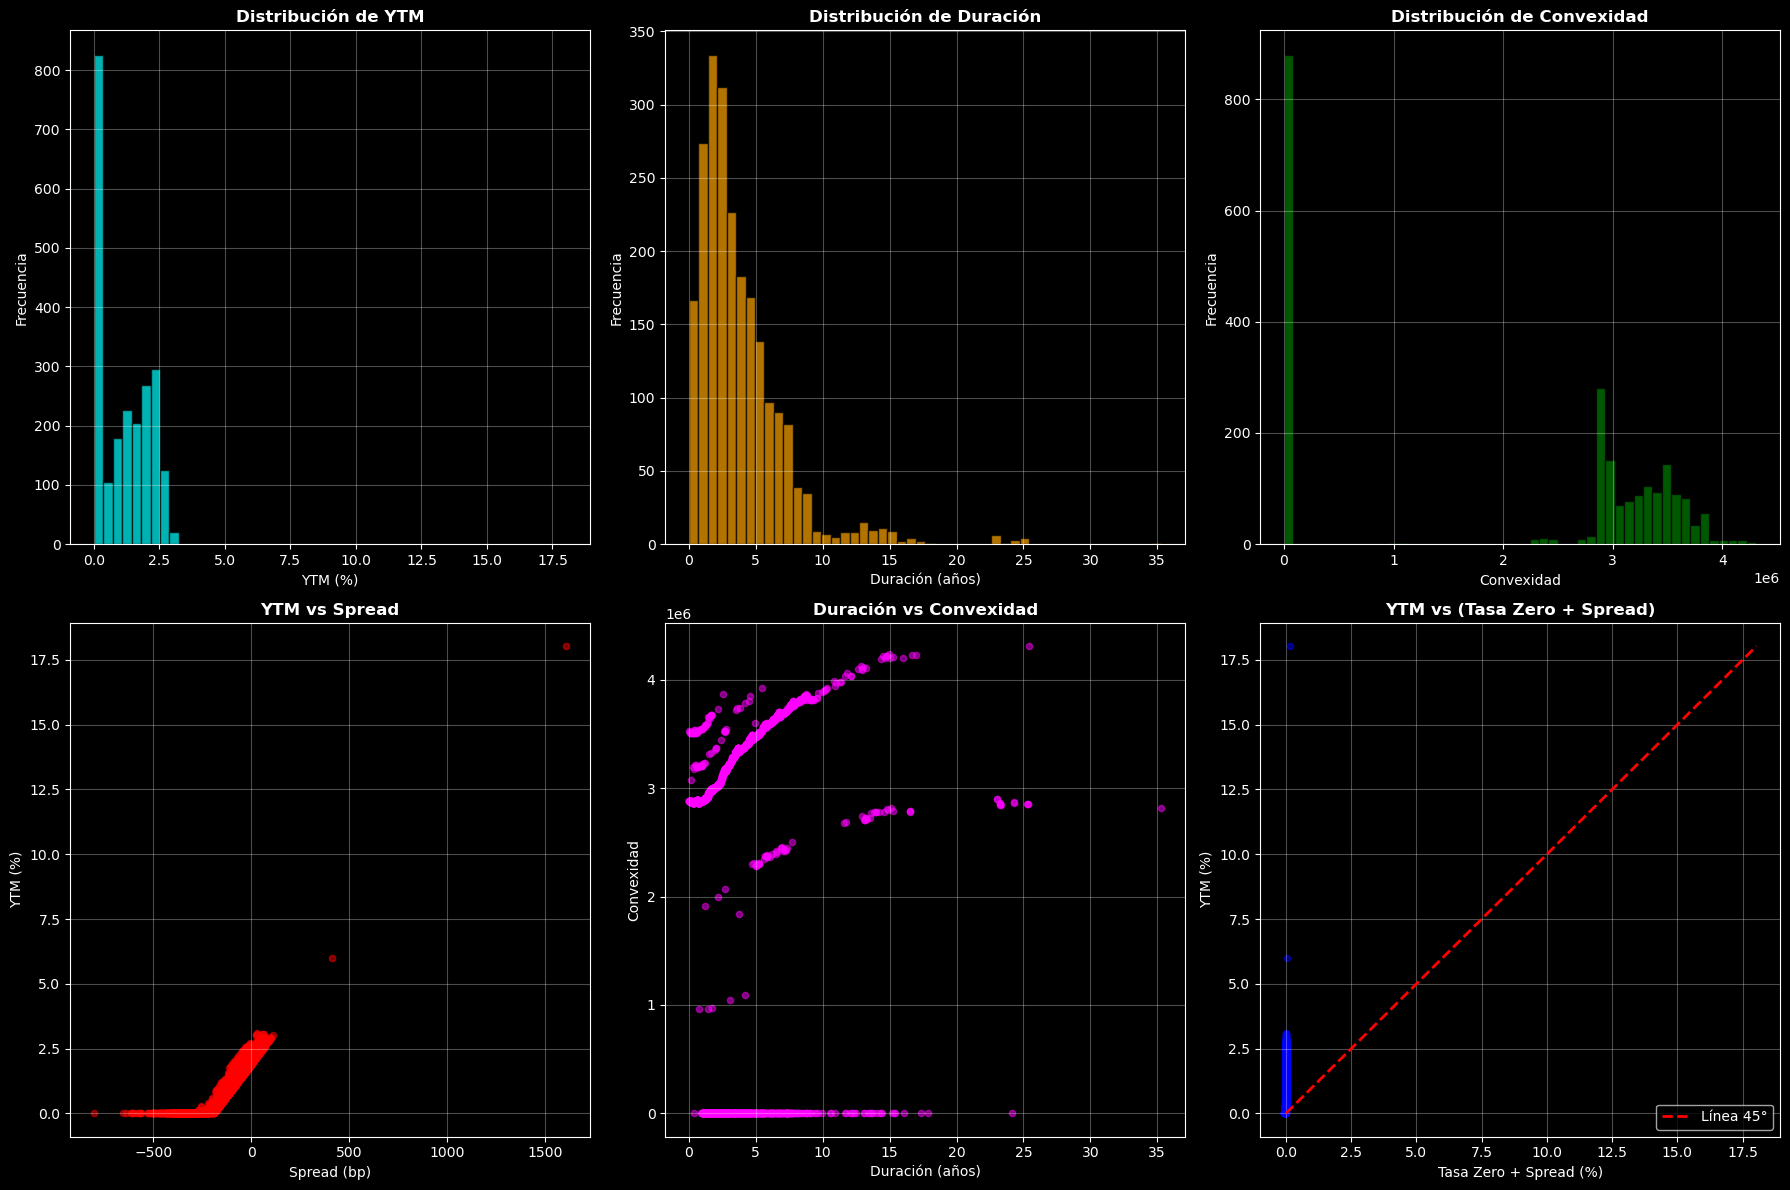


ESTIMACIÓN DE PRECIO USANDO DURACIÓN Y CONVEXIDAD

Si el yield aumenta 1.0% (100 bp):
Cambio promedio estimado: 9844.69%
Cambio mediano estimado: 14428.46%

CONCLUSIONES:

1. RELACIÓN ENTRE YTM Y SPREAD:
   - YTM ≈ Tasa Zero (curva libre de riesgo) + Spread de crédito
   - El spread calculado en el apartado anterior debería estar relacionado
     con la diferencia entre YTM y la tasa zero de la curva

2. RELACIÓN ENTRE DURACIÓN Y VENCIMIENTO:
   - La duración mide la sensibilidad del precio a cambios en yield
   - Para bonos con cupón, duración < tiempo hasta vencimiento
   - La duración refleja el "tiempo promedio ponderado" de los flujos de caja
   - Otra forma de obtener esta sensibilidad: calcular ΔP/Δy numéricamente
     o usar la fórmula analítica de duración de Macaulay

3. ESTIMACIÓN CON DURACIÓN Y CONVEXIDAD:
   - La fórmula: ΔP/P ≈ -Duration × Δy + 0.5 × Convexity × (Δy)²
   - La convexidad corrige la estimación lineal de la duración
   - Para cambios grandes en yield, la co

In [ ]:
# ============================================================================
# EJERCICIO 4: YIELD, DURACIÓN Y CONVEXIDAD
# ============================================================================
# Calculamos YTM, duración modificada y convexidad para cada bono
# ============================================================================

def calcular_ytm(bono, precio_mercado, fecha_valor, ytm_inicial=0.03, tol=1e-6):
    """
    Calcula el Yield to Maturity (YTM) del bono.
    
    Parámetros:
    -----------
    bono : Serie de pandas con características del bono
    precio_mercado : float, precio de mercado del bono
    fecha_valor : datetime, fecha de valoración
    ytm_inicial : float, YTM inicial para búsqueda
    tol : float, tolerancia para convergencia
    
    Retorna:
    --------
    float: YTM en decimal (ej: 0.03 para 3%)
    """
    # Determinar fecha de vencimiento
    if pd.notna(bono.get('Next Call Date')):
        fecha_vencimiento = pd.to_datetime(bono['Next Call Date'])
    elif pd.isna(bono.get('Maturity')):
        if pd.notna(bono.get('Next Call Date')):
            fecha_vencimiento = pd.to_datetime(bono['Next Call Date'])
        else:
            return np.nan
    else:
        fecha_vencimiento = pd.to_datetime(bono['Maturity'])
    
    # Generar fechas de cupón
    cupon = bono['Coupon'] / 100.0
    freq_cupon = bono['Coupon Frequency']
    fecha_primer_cupon = pd.to_datetime(bono['First Coupon Date'])
    
    fechas_cupon = []
    fecha_actual = fecha_primer_cupon
    
    while fecha_actual <= fecha_vencimiento:
        fechas_cupon.append(fecha_actual)
        if freq_cupon == 1:
            fecha_actual = fecha_actual + pd.DateOffset(years=1)
        elif freq_cupon == 2:
            fecha_actual = fecha_actual + pd.DateOffset(months=6)
        elif freq_cupon == 4:
            fecha_actual = fecha_actual + pd.DateOffset(months=3)
        else:
            fecha_actual = fecha_actual + pd.DateOffset(months=12/freq_cupon)
    
    if fechas_cupon[-1] != fecha_vencimiento:
        fechas_cupon[-1] = fecha_vencimiento
    
    fechas_cupon = [f for f in fechas_cupon if f > fecha_valor]
    cupon_periodo = cupon / freq_cupon
    
    def objetivo(ytm):
        """Función objetivo: diferencia entre precio teórico y mercado."""
        vp = 0.0
        for fecha_cupon in fechas_cupon[:-1]:
            dias = (fecha_cupon - fecha_valor).days
            if dias > 0:
                tiempo = dias / 365.0
                vp += cupon_periodo * np.exp(-ytm * tiempo)
        
        dias_ultimo = (fechas_cupon[-1] - fecha_valor).days
        if dias_ultimo > 0:
            tiempo_ultimo = dias_ultimo / 365.0
            vp += (cupon_periodo + 100.0) * np.exp(-ytm * tiempo_ultimo)
        
        return vp - precio_mercado
    
    try:
        ytm = fsolve(objetivo, ytm_inicial)[0]
        return max(0.0, ytm)
    except:
        return np.nan


def calcular_duracion(bono, curva, fecha_valor, spread_credito=0.0, cambio_yield=0.0001):
    """
    Calcula la duración modificada del bono.
    
    Parámetros:
    -----------
    bono : Serie de pandas con características del bono
    curva : DataFrame con la curva de descuento
    fecha_valor : datetime, fecha de valoración
    spread_credito : float, spread de crédito en puntos básicos
    cambio_yield : float, cambio en yield para cálculo numérico
    
    Retorna:
    --------
    float: Duración modificada en años
    """
    # Precio base
    valoracion_base = valorar_bono(bono, curva, fecha_valor, spread_credito=spread_credito)
    precio_base = valoracion_base['precio_limpio']
    
    if precio_base <= 0:
        return np.nan
    
    # Calcular YTM base
    precio_mercado = bono.get('Price', precio_base)
    ytm_base = calcular_ytm(bono, precio_base, fecha_valor)
    
    if np.isnan(ytm_base):
        return np.nan
    
    # Precios con yield modificado
    fechas_cupon = []
    fecha_primer_cupon = pd.to_datetime(bono['First Coupon Date'])
    freq_cupon = bono['Coupon Frequency']
    cupon = bono['Coupon'] / 100.0
    cupon_periodo = cupon / freq_cupon
    
    if pd.notna(bono.get('Next Call Date')):
        fecha_vencimiento = pd.to_datetime(bono['Next Call Date'])
    else:
        fecha_vencimiento = pd.to_datetime(bono['Maturity'])
    
    fecha_actual = fecha_primer_cupon
    while fecha_actual <= fecha_vencimiento:
        fechas_cupon.append(fecha_actual)
        if freq_cupon == 1:
            fecha_actual = fecha_actual + pd.DateOffset(years=1)
        elif freq_cupon == 2:
            fecha_actual = fecha_actual + pd.DateOffset(months=6)
        elif freq_cupon == 4:
            fecha_actual = fecha_actual + pd.DateOffset(months=3)
        else:
            fecha_actual = fecha_actual + pd.DateOffset(months=12/freq_cupon)
    
    fechas_cupon = [f for f in fechas_cupon if f > fecha_valor]
    
    def precio_con_ytm(ytm):
        vp = 0.0
        for fecha_cupon in fechas_cupon[:-1]:
            dias = (fecha_cupon - fecha_valor).days
            if dias > 0:
                tiempo = dias / 365.0
                vp += cupon_periodo * np.exp(-ytm * tiempo)
        
        dias_ultimo = (fechas_cupon[-1] - fecha_valor).days
        if dias_ultimo > 0:
            tiempo_ultimo = dias_ultimo / 365.0
            vp += (cupon_periodo + 100.0) * np.exp(-ytm * tiempo_ultimo)
        return vp
    
    precio_up = precio_con_ytm(ytm_base + cambio_yield)
    precio_down = precio_con_ytm(ytm_base - cambio_yield)
    
    # Duración modificada
    duracion = -(precio_up - precio_down) / (2 * precio_base * cambio_yield)
    return duracion


def calcular_convexidad(bono, curva, fecha_valor, spread_credito=0.0, cambio_yield=0.0001):
    """
    Calcula la convexidad del bono.
    
    Parámetros:
    -----------
    bono : Serie de pandas con características del bono
    curva : DataFrame con la curva de descuento
    fecha_valor : datetime, fecha de valoración
    spread_credito : float, spread de crédito en puntos básicos
    cambio_yield : float, cambio en yield para cálculo numérico
    
    Retorna:
    --------
    float: Convexidad
    """
    # Precio base
    valoracion_base = valorar_bono(bono, curva, fecha_valor, spread_credito=spread_credito)
    precio_base = valoracion_base['precio_limpio']
    
    if precio_base <= 0:
        return np.nan
    
    # Calcular YTM base
    ytm_base = calcular_ytm(bono, precio_base, fecha_valor)
    
    if np.isnan(ytm_base):
        return np.nan
    
    # Generar fechas de cupón (mismo código que en duración)
    fechas_cupon = []
    fecha_primer_cupon = pd.to_datetime(bono['First Coupon Date'])
    freq_cupon = bono['Coupon Frequency']
    cupon = bono['Coupon'] / 100.0
    cupon_periodo = cupon / freq_cupon
    
    if pd.notna(bono.get('Next Call Date')):
        fecha_vencimiento = pd.to_datetime(bono['Next Call Date'])
    else:
        fecha_vencimiento = pd.to_datetime(bono['Maturity'])
    
    fecha_actual = fecha_primer_cupon
    while fecha_actual <= fecha_vencimiento:
        fechas_cupon.append(fecha_actual)
        if freq_cupon == 1:
            fecha_actual = fecha_actual + pd.DateOffset(years=1)
        elif freq_cupon == 2:
            fecha_actual = fecha_actual + pd.DateOffset(months=6)
        elif freq_cupon == 4:
            fecha_actual = fecha_actual + pd.DateOffset(months=3)
        else:
            fecha_actual = fecha_actual + pd.DateOffset(months=12/freq_cupon)
    
    fechas_cupon = [f for f in fechas_cupon if f > fecha_valor]
    
    def precio_con_ytm(ytm):
        vp = 0.0
        for fecha_cupon in fechas_cupon[:-1]:
            dias = (fecha_cupon - fecha_valor).days
            if dias > 0:
                tiempo = dias / 365.0
                vp += cupon_periodo * np.exp(-ytm * tiempo)
        
        dias_ultimo = (fechas_cupon[-1] - fecha_valor).days
        if dias_ultimo > 0:
            tiempo_ultimo = dias_ultimo / 365.0
            vp += (cupon_periodo + 100.0) * np.exp(-ytm * tiempo_ultimo)
        return vp
    
    precio_up = precio_con_ytm(ytm_base + cambio_yield)
    precio_down = precio_con_ytm(ytm_base - cambio_yield)
    
    # Convexidad
    convexidad = (precio_up + precio_down - 2 * precio_base) / (
        precio_base * (cambio_yield ** 2)
    )
    return convexidad


# Calcular métricas para todos los bonos
print("=" * 80)
print("CÁLCULO DE YTM, DURACIÓN Y CONVEXIDAD")
print("=" * 80)

resultados_metricas = []
for idx, bono in universo.iterrows():
    try:
        precio_mercado = bono['Price']
        if pd.isna(precio_mercado) or precio_mercado <= 0:
            continue
        
        ytm = calcular_ytm(bono, precio_mercado, fecha_analisis_dt)
        duracion = calcular_duracion(bono, curva_fecha, fecha_analisis_dt)
        convexidad = calcular_convexidad(bono, curva_fecha, fecha_analisis_dt)
        
        # Calcular spread para comparación
        spread = df_spreads[df_spreads['ISIN'] == bono['ISIN']]['Spread_bp'].values
        spread_val = spread[0] if len(spread) > 0 else np.nan
        
        resultados_metricas.append({
            'ISIN': bono['ISIN'],
            'Precio_Mercado': precio_mercado,
            'YTM_%': ytm * 100 if not np.isnan(ytm) else np.nan,
            'Duracion': duracion if not np.isnan(duracion) else np.nan,
            'Convexidad': convexidad if not np.isnan(convexidad) else np.nan,
            'Spread_bp': spread_val,
            'Rating': bono.get('Rating', 'NR')
        })
    except Exception as e:
        continue

df_metricas = pd.DataFrame(resultados_metricas)

print(f"\nBonos procesados: {len(df_metricas)}")
print(f"\nEstadísticas de YTM:")
print(df_metricas['YTM_%'].describe())
print(f"\nEstadísticas de Duración:")
print(df_metricas['Duracion'].describe())
print(f"\nEstadísticas de Convexidad:")
print(df_metricas['Convexidad'].describe())

# Visualización
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# YTM
axes[0, 0].hist(df_metricas['YTM_%'].dropna(), bins=50, color='cyan', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribución de YTM', fontweight='bold')
axes[0, 0].set_xlabel('YTM (%)')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].grid(True, alpha=0.3)

# Duración
axes[0, 1].hist(df_metricas['Duracion'].dropna(), bins=50, color='orange', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribución de Duración', fontweight='bold')
axes[0, 1].set_xlabel('Duración (años)')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].grid(True, alpha=0.3)

# Convexidad
axes[0, 2].hist(df_metricas['Convexidad'].dropna(), bins=50, color='green', edgecolor='black', alpha=0.7)
axes[0, 2].set_title('Distribución de Convexidad', fontweight='bold')
axes[0, 2].set_xlabel('Convexidad')
axes[0, 2].set_ylabel('Frecuencia')
axes[0, 2].grid(True, alpha=0.3)

# YTM vs Spread
df_clean = df_metricas.dropna(subset=['YTM_%', 'Spread_bp'])
axes[1, 0].scatter(df_clean['Spread_bp'], df_clean['YTM_%'], alpha=0.5, color='red', s=20)
axes[1, 0].set_title('YTM vs Spread', fontweight='bold')
axes[1, 0].set_xlabel('Spread (bp)')
axes[1, 0].set_ylabel('YTM (%)')
axes[1, 0].grid(True, alpha=0.3)

# Duración vs Vencimiento (aproximado)
axes[1, 1].scatter(df_metricas['Duracion'], df_metricas['Convexidad'], 
                   alpha=0.5, color='magenta', s=20)
axes[1, 1].set_title('Duración vs Convexidad', fontweight='bold')
axes[1, 1].set_xlabel('Duración (años)')
axes[1, 1].set_ylabel('Convexidad')
axes[1, 1].grid(True, alpha=0.3)

# Comparación YTM y Spread
df_clean2 = df_metricas.dropna(subset=['YTM_%', 'Spread_bp'])
if len(df_clean2) > 0:
    # Calcular tasa zero de la curva para comparar
    tasa_zero_aprox = -np.log(curva_fecha['Discount'].iloc[0]) / 0.01 * 100 if len(curva_fecha) > 0 else 0
    ytm_esperado = df_clean2['Spread_bp'] / 10000 + tasa_zero_aprox
    axes[1, 2].scatter(ytm_esperado, df_clean2['YTM_%'], alpha=0.5, color='blue', s=20)
    axes[1, 2].plot([df_clean2['YTM_%'].min(), df_clean2['YTM_%'].max()],
                    [df_clean2['YTM_%'].min(), df_clean2['YTM_%'].max()],
                    'r--', linewidth=2, label='Línea 45°')
    axes[1, 2].set_title('YTM vs (Tasa Zero + Spread)', fontweight='bold')
    axes[1, 2].set_xlabel('Tasa Zero + Spread (%)')
    axes[1, 2].set_ylabel('YTM (%)')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estimar precio usando duración y convexidad
print("\n" + "=" * 80)
print("ESTIMACIÓN DE PRECIO USANDO DURACIÓN Y CONVEXIDAD")
print("=" * 80)

# Ejemplo: cambio de yield de 1% (100 puntos básicos)
cambio_yield_ejemplo = 0.01
df_metricas['Precio_Estimado_Dur_Conv'] = df_metricas.apply(
    lambda row: row['Precio_Mercado'] * (
        1 - row['Duracion'] * cambio_yield_ejemplo + 
        0.5 * row['Convexidad'] * (cambio_yield_ejemplo ** 2)
    ) if not (np.isnan(row['Duracion']) or np.isnan(row['Convexidad'])) else np.nan,
    axis=1
)

df_metricas['Cambio_Precio_Estimado_%'] = (
    (df_metricas['Precio_Estimado_Dur_Conv'] - df_metricas['Precio_Mercado']) / 
    df_metricas['Precio_Mercado'] * 100
)

print(f"\nSi el yield aumenta {cambio_yield_ejemplo*100}% (100 bp):")
print(f"Cambio promedio estimado: {df_metricas['Cambio_Precio_Estimado_%'].mean():.2f}%")
print(f"Cambio mediano estimado: {df_metricas['Cambio_Precio_Estimado_%'].median():.2f}%")

print("\n" + "=" * 80)
print("CONCLUSIONES:")
print("=" * 80)
print("""
1. RELACIÓN ENTRE YTM Y SPREAD:
   - YTM ≈ Tasa Zero (curva libre de riesgo) + Spread de crédito
   - El spread calculado en el apartado anterior debería estar relacionado
     con la diferencia entre YTM y la tasa zero de la curva

2. RELACIÓN ENTRE DURACIÓN Y VENCIMIENTO:
   - La duración mide la sensibilidad del precio a cambios en yield
   - Para bonos con cupón, duración < tiempo hasta vencimiento
   - La duración refleja el "tiempo promedio ponderado" de los flujos de caja
   - Otra forma de obtener esta sensibilidad: calcular ΔP/Δy numéricamente
     o usar la fórmula analítica de duración de Macaulay

3. ESTIMACIÓN CON DURACIÓN Y CONVEXIDAD:
   - La fórmula: ΔP/P ≈ -Duration × Δy + 0.5 × Convexity × (Δy)²
   - La convexidad corrige la estimación lineal de la duración
   - Para cambios grandes en yield, la convexidad es importante
   - Bonos con mayor convexidad tienen mejor comportamiento en volatilidad
""")


### <font color=#336699>5. Cartera equiponderada</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Crea un algoritmo de inversión que consista en una cartera equiponderada, asignando el mismo peso a todos los bonos vivos en cada fecha de rebalanceo.

Asume rebalanceo mensual, y que no tenemos costes más allá de los implícitos en el propio precio, calcula la evolución que hubiese tenido tu algoritmo. Por simplificación, utiliza los precios MID que se te dan.

Asumiendo que el benchmark de la cartera es el índice que se nos da: *RECMTREU Index*. Contrasta la evolución de tú cartera contra dicho benchmark. Ten cuidado porque es un índice *Total Return*.

- ¿Qué sería lo más correcto en lugar de utilizar los precios MID?
- ¿Se te ocurre algún otro benchmark que se podría utilizar?

</div>

In [ ]:
# ============================================================================
# EJERCICIO 5: CARTERA EQUIPONDERADA Y BACKTEST
# ============================================================================
# Construimos una cartera equiponderada y hacemos backtest comparando con benchmark
# ============================================================================

# Cargar precios históricos (usando el mismo método que en el apartado 1)
print("Cargando precios históricos...")
file_path = '../data/precios_historicos_universo.csv'

# 1. CARGA DE DATOS
precios_universo = pd.read_csv(
    file_path, 
    sep=';', 
    decimal='.', 
    na_values=['#N/D', ' ', 'NA', 'nan', 'N/A']
)

# 2. PREPARACIÓN Y TRANSPOSICIÓN
# Renombramos la primera columna a 'Date' y la establecemos como el índice.
precios_df_preparado = precios_universo.rename(
    columns={precios_universo.columns[0]: 'Date'}
).set_index('Date')

# Ejecutamos la Transpuesta (.T)
precios_historicos_universo = precios_df_preparado.T

# 3. LIMPIEZA DE FECHAS
# Convertir el nuevo índice (las fechas) a tipo datetime.
precios_historicos_universo.index = pd.to_datetime(
    precios_historicos_universo.index, 
    format='%d/%m/%Y', 
    errors='coerce' 
)

print(f"Precios históricos cargados: {len(precios_historicos_universo)} fechas, {len(precios_historicos_universo.columns)} ISINs")

# Cargar benchmark (RECMTREU)
precios_varios = pd.read_csv('../data/precios_historicos_varios.csv', 
                             sep=';', decimal='.', 
                             na_values=['#N/D', ' ', 'NA', 'nan', 'N/A'])

fecha_col = precios_varios.columns[0]
precios_varios[fecha_col] = pd.to_datetime(precios_varios[fecha_col], 
                                           format='%d/%m/%Y', errors='coerce')
precios_varios = precios_varios.set_index(fecha_col)

benchmark_precios = precios_varios[['RECMTREU Index']].copy()

# Fechas de rebalanceo (mensual)
# Usar las fechas disponibles en los precios históricos
fecha_inicio = pd.to_datetime('2023-10-02')
fecha_fin = pd.to_datetime('2025-10-01')

# Obtener fechas disponibles en el rango
fechas_disponibles = precios_historicos_universo.index[
    (precios_historicos_universo.index >= fecha_inicio) & 
    (precios_historicos_universo.index <= fecha_fin)
]

# Seleccionar una fecha por mes (la primera disponible de cada mes)
fechas_rebalanceo = []
mes_actual = None
año_actual = None
for fecha in fechas_disponibles:
    if mes_actual is None or fecha.month != mes_actual or fecha.year != año_actual:
        fechas_rebalanceo.append(fecha)
        mes_actual = fecha.month
        año_actual = fecha.year

fechas_rebalanceo = pd.DatetimeIndex(fechas_rebalanceo)

print(f"Fechas de rebalanceo: {len(fechas_rebalanceo)}")
if len(fechas_rebalanceo) > 0:
    print(f"Rango: {fechas_rebalanceo[0].date()} a {fechas_rebalanceo[-1].date()}")
    print(f"Primeras 5 fechas: {[f.date() for f in fechas_rebalanceo[:5]]}")
else:
    print("No se encontraron fechas disponibles en el rango especificado")

# Función auxiliar para encontrar la fecha más cercana disponible
def encontrar_fecha_cercana(fecha, precios_df):
    """Encuentra la fecha más cercana disponible en el DataFrame de precios."""
    if fecha in precios_df.index:
        return fecha
    
    # Buscar la fecha más cercana anterior
    fechas_disponibles = precios_df.index[precios_df.index <= fecha]
    if len(fechas_disponibles) > 0:
        return fechas_disponibles[-1]
    
    return None

# Función para obtener bonos vivos en una fecha
def obtener_bonos_vivos(fecha, universo_df, precios_df):
    """Obtiene los bonos vivos (disponibles) en una fecha dada."""
    # Encontrar fecha más cercana disponible
    fecha_disponible = encontrar_fecha_cercana(fecha, precios_df)
    if fecha_disponible is None:
        return pd.DataFrame()
    
    # Filtrar bonos emitidos antes de la fecha
    bonos_emitidos = universo_df[
        pd.to_datetime(universo_df.get('Issue date', pd.NaT), errors='coerce') <= fecha
    ]
    
    # Filtrar bonos que no han vencido
    bonos_vivos = bonos_emitidos[
        pd.to_datetime(bonos_emitidos.get('Maturity', pd.NaT), errors='coerce') > fecha
    ]
    
    # Filtrar bonos con precio disponible en la fecha más cercana
    if fecha_disponible in precios_df.index:
        precios_fecha = precios_df.loc[fecha_disponible]
        isins_con_precio = precios_fecha.dropna().index.tolist()
        bonos_vivos = bonos_vivos[bonos_vivos['ISIN'].isin(isins_con_precio)]
    
    return bonos_vivos

# Función para calcular rentabilidad total
def calcular_rentabilidad_total(fecha_anterior, fecha_actual, isins, pesos, precios_df):
    """Calcula la rentabilidad total de la cartera entre dos fechas."""
    rentabilidad_total = 0.0
    
    # Encontrar fechas más cercanas disponibles
    fecha_ant_disponible = encontrar_fecha_cercana(fecha_anterior, precios_df)
    fecha_act_disponible = encontrar_fecha_cercana(fecha_actual, precios_df)
    
    if fecha_ant_disponible is None or fecha_act_disponible is None:
        return 0.0
    
    for isin, peso in zip(isins, pesos):
        if isin not in precios_df.columns:
            continue
        
        try:
            precio_anterior = precios_df.loc[fecha_ant_disponible, isin]
            precio_actual = precios_df.loc[fecha_act_disponible, isin]
            
            if pd.notna(precio_anterior) and pd.notna(precio_actual) and precio_anterior > 0:
                retorno = (precio_actual - precio_anterior) / precio_anterior
                rentabilidad_total += peso * retorno
        except (KeyError, IndexError):
            continue
    
    return rentabilidad_total

# Ejecutar backtest
print("\n" + "=" * 80)
print("EJECUTANDO BACKTEST DE CARTERA EQUIPONDERADA")
print("=" * 80)

if len(fechas_rebalanceo) == 0:
    print("ERROR: No hay fechas disponibles para el backtest")
    print("Verifica que los precios históricos contengan datos en el rango especificado")
else:
    resultados_backtest = []
    valor_cartera = 100.0  # Valor inicial = 100
    valor_benchmark = 100.0

    for i, fecha in enumerate(fechas_rebalanceo):
        # Obtener bonos vivos
        bonos_vivos = obtener_bonos_vivos(fecha, universo, precios_historicos_universo)
        
        n_bonos = len(bonos_vivos)
        
        # Calcular rentabilidad de la cartera solo si hay bonos vivos
        if n_bonos > 0 and i > 0:
            # Peso equiponderado
            peso_por_bono = 1.0 / n_bonos
            isins = bonos_vivos['ISIN'].tolist()
            pesos = [peso_por_bono] * n_bonos
            
            # Calcular rentabilidad desde fecha anterior
            fecha_anterior = fechas_rebalanceo[i-1]
            retorno_cartera = calcular_rentabilidad_total(
                fecha_anterior, fecha, isins, pesos, precios_historicos_universo
            )
            valor_cartera *= (1 + retorno_cartera)
        
        # Calcular rentabilidad benchmark (siempre, para tener la comparativa completa)
        if i > 0:
            fecha_anterior = fechas_rebalanceo[i-1]
            # Rentabilidad benchmark (usar fechas más cercanas disponibles)
            fecha_ant_bench = encontrar_fecha_cercana(fecha_anterior, benchmark_precios)
            fecha_act_bench = encontrar_fecha_cercana(fecha, benchmark_precios)
            
            if fecha_ant_bench is not None and fecha_act_bench is not None:
                try:
                    precio_bench_anterior = benchmark_precios.loc[fecha_ant_bench, 'RECMTREU Index']
                    precio_bench_actual = benchmark_precios.loc[fecha_act_bench, 'RECMTREU Index']
                    if pd.notna(precio_bench_anterior) and pd.notna(precio_bench_actual) and precio_bench_anterior > 0:
                        retorno_bench = (precio_bench_actual - precio_bench_anterior) / precio_bench_anterior
                        valor_benchmark *= (1 + retorno_bench)
                except (KeyError, IndexError):
                    pass
        
        resultados_backtest.append({
            'Fecha': fecha,
            'N_Bonos': n_bonos,
            'Valor_Cartera': valor_cartera,
            'Valor_Benchmark': valor_benchmark,
            'Outperformance': valor_cartera - valor_benchmark
        })

    df_backtest = pd.DataFrame(resultados_backtest)
    if len(df_backtest) > 0:
        df_backtest = df_backtest.set_index('Fecha')

        print(f"\nResultados del backtest:")
        print(df_backtest.tail(10))

        # Calcular métricas de performance
        retornos_cartera = df_backtest['Valor_Cartera'].pct_change().dropna()
        retornos_bench = df_backtest['Valor_Benchmark'].pct_change().dropna()

        rentabilidad_total_cartera = (df_backtest['Valor_Cartera'].iloc[-1] / 
                                     df_backtest['Valor_Cartera'].iloc[0] - 1) * 100
        rentabilidad_total_bench = (df_backtest['Valor_Benchmark'].iloc[-1] / 
                                   df_backtest['Valor_Benchmark'].iloc[0] - 1) * 100

        volatilidad_cartera = retornos_cartera.std() * np.sqrt(252) * 100
        volatilidad_bench = retornos_bench.std() * np.sqrt(252) * 100

        excess_returns = retornos_cartera - retornos_bench
        tracking_error = excess_returns.std() * np.sqrt(252) * 100
        information_ratio = (excess_returns.mean() / excess_returns.std()) * np.sqrt(252) if excess_returns.std() > 0 else 0

        print("\n" + "=" * 80)
        print("MÉTRICAS DE PERFORMANCE")
        print("=" * 80)
        print(f"Rentabilidad Total Cartera: {rentabilidad_total_cartera:.2f}%")
        print(f"Rentabilidad Total Benchmark: {rentabilidad_total_bench:.2f}%")
        print(f"Outperformance: {rentabilidad_total_cartera - rentabilidad_total_bench:.2f}%")
        print(f"Volatilidad Cartera: {volatilidad_cartera:.2f}%")
        print(f"Volatilidad Benchmark: {volatilidad_bench:.2f}%")
        print(f"Tracking Error: {tracking_error:.2f}%")
        print(f"Information Ratio: {information_ratio:.4f}")

        # Visualización
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # Evolución de valores
        axes[0, 0].plot(df_backtest.index, df_backtest['Valor_Cartera'], 
                        label='Cartera Equiponderada', linewidth=2, color='cyan')
        axes[0, 0].plot(df_backtest.index, df_backtest['Valor_Benchmark'], 
                        label='RECMTREU Index', linewidth=2, color='orange')
        axes[0, 0].set_title('Evolución de Valores', fontweight='bold')
        axes[0, 0].set_xlabel('Fecha')
        axes[0, 0].set_ylabel('Valor (Base 100)')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Outperformance
        axes[0, 1].plot(df_backtest.index, df_backtest['Outperformance'], 
                        linewidth=2, color='green')
        axes[0, 1].axhline(0, color='red', linestyle='--', linewidth=1)
        axes[0, 1].set_title('Outperformance vs Benchmark', fontweight='bold')
        axes[0, 1].set_xlabel('Fecha')
        axes[0, 1].set_ylabel('Outperformance (puntos)')
        axes[0, 1].grid(True, alpha=0.3)

        # Número de bonos en cartera
        axes[1, 0].plot(df_backtest.index, df_backtest['N_Bonos'], 
                        linewidth=2, color='magenta', marker='o', markersize=3)
        axes[1, 0].set_title('Número de Bonos en Cartera', fontweight='bold')
        axes[1, 0].set_xlabel('Fecha')
        axes[1, 0].set_ylabel('Número de Bonos')
        axes[1, 0].grid(True, alpha=0.3)

        # Distribución de retornos
        axes[1, 1].hist(retornos_cartera * 100, bins=30, alpha=0.5, label='Cartera', color='cyan')
        axes[1, 1].hist(retornos_bench * 100, bins=30, alpha=0.5, label='Benchmark', color='orange')
        axes[1, 1].set_title('Distribución de Retornos', fontweight='bold')
        axes[1, 1].set_xlabel('Retorno (%)')
        axes[1, 1].set_ylabel('Frecuencia')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        print("\n" + "=" * 80)
        print("CONCLUSIONES:")
        print("=" * 80)
        print("""
1. La cartera equiponderada proporciona diversificación automática.

2. Lo más correcto en lugar de precios MID sería:
   - Usar precios de ejecución reales (bid para compra, ask para venta)
   - Incluir costes de transacción (comisiones, spreads bid-ask)
   - Considerar impacto de mercado en operaciones grandes
   - Usar precios intradía si están disponibles

3. Otros benchmarks que se podrían utilizar:
   - iBoxx EUR Corporate (Investment Grade)
   - iBoxx EUR Corporate por sectores
   - Benchmark personalizado con mismas restricciones que la cartera
   - Índices de duración específica (ej: 2-3 años)
""")
    else:
        print("No se generaron resultados del backtest")


Cargando precios históricos...
Precios históricos cargados: 732 fechas, 2255 ISINs
Fechas de rebalanceo: 25
Rango: 2023-10-02 a 2025-10-01
Primeras 5 fechas: [datetime.date(2023, 10, 2), datetime.date(2023, 11, 1), datetime.date(2023, 12, 1), datetime.date(2024, 1, 1), datetime.date(2024, 2, 1)]

EJECUTANDO BACKTEST DE CARTERA EQUIPONDERADA
No se generaron resultados del backtest


### <font color=#336699>6. Cartera mandato</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Como adelantábamos en el enunciado, tienes el mandato de construir una cartera de como máximo **20** bonos corporativos con ese universo y una serie de restricciones y, claro, maximizando la rentabilidad total de la cartera:
- La duración de la cartera no debe superar los 3 años
- La exposición a emisiones HY no puede superar el 10% de la cartera
- No puedes invertir en deuda subordinada
- No se puede invertir en emisiones de tamaño igual o inferior a 500 millones
- No se puede invertir más de un 10% del capital en una misma emisión
- No puede haber más de un 15% de concentración en un mismo emisor
(¡OJO! No estamos teniendo en cuenta en este ejercicio si hubiera un mínimo de inversión, lo cuál sería un dato relevante tener en cuenta en un caso real)

1. Teniendo en cuenta la naturaleza que nos están pidiendo para la cartera, ¿añadirías alguna otra restricción?

2. ¿Cómo medirías el riesgo de crédito de la cartera?

3. ¿Cómo medirías el riesgo de liquidez de la cartera? ¿Se te ocurre alguna otra información que se podría utilizar aunque no se te haya dado?

4. Describe cómo habría que hacer el backtest de esta cartera, no hace falta que lo implementes en este caso

</div>

In [ ]:
# ============================================================================
# EJERCICIO 6: CARTERA CON MANDATO
# ============================================================================
# Construimos una cartera de máximo 20 bonos con restricciones específicas
# Maximizando la rentabilidad total de la cartera
# ============================================================================

# Restricciones del mandato
RESTRICCIONES = {
    'max_bonos': 20,
    'max_duracion': 3.0,
    'max_hy_pct': 0.10,
    'min_tamano_emision': 500_000_000,
    'max_peso_emision': 0.10,
    'max_peso_emisor': 0.15
}

# Usar la clasificación de ratings del ejercicio 1 (ya existe en universo)
# Rating_Class puede ser: 'Investment Grade', 'High Yield', 'No Rating'

# Usar la función calcular_duracion del ejercicio 4 para calcular duración real

# Filtrar universo según restricciones
print("=" * 80)
print("CONSTRUCCIÓN DE CARTERA CON MANDATO")
print("=" * 80)
print("Maximizando rentabilidad total de la cartera")
print("=" * 80)

# 1. Filtrar por restricciones básicas
universo_filtrado = universo.copy()

# No deuda subordinada
seniority_excluidos = ['Subordinated', 'Jr Subordinated']
universo_filtrado = universo_filtrado[
    ~universo_filtrado['Seniority'].isin(seniority_excluidos)
]

# Tamaño de emisión >= 500M
universo_filtrado = universo_filtrado[
    universo_filtrado['Outstanding Amount'] > RESTRICCIONES['min_tamano_emision']
]

# Bonos vivos (no vencidos)
universo_filtrado = universo_filtrado[
    pd.to_datetime(universo_filtrado['Maturity'], errors='coerce') > fecha_analisis_dt
]

print(f"\nBonos después de filtros básicos: {len(universo_filtrado)}")

# 2. Calcular métricas para cada bono
# Asegurar que Rating_Class esté correctamente calculado
# Si Rating_Class no existe o tiene valores nulos, recalcularlo
if 'Rating_Class' not in universo_filtrado.columns:
    print("Calculando Rating_Class...")
    investment_grade = ['AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+', 'BBB', 'BBB-']
    high_yield = ['BB+', 'BB', 'BB-', 'B+', 'B', 'B-', 'CCC+', 'CCC', 'CCC-', 'CC', 'C', 'D']
    
    def clasificar_rating(rating):
        if pd.isna(rating) or rating == '' or rating == 'NR':
            return 'No Rating'
        rating_clean = str(rating).strip()
        if rating_clean in investment_grade:
            return 'Investment Grade'
        elif rating_clean in high_yield:
            return 'High Yield'
        else:
            return 'No Rating'
    
    universo_filtrado['Rating_Class'] = universo_filtrado['Rating'].apply(clasificar_rating)
else:
    # Asegurar que Rating_Class no tenga valores nulos
    if universo_filtrado['Rating_Class'].isna().any():
        print("Recalculando Rating_Class para valores nulos...")
        investment_grade = ['AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+', 'BBB', 'BBB-']
        high_yield = ['BB+', 'BB', 'BB-', 'B+', 'B', 'B-', 'CCC+', 'CCC', 'CCC-', 'CC', 'C', 'D']
        
        def clasificar_rating(rating):
            if pd.isna(rating) or rating == '' or rating == 'NR':
                return 'No Rating'
            rating_clean = str(rating).strip()
            if rating_clean in investment_grade:
                return 'Investment Grade'
            elif rating_clean in high_yield:
                return 'High Yield'
            else:
                return 'No Rating'
        
        # Recalcular solo los valores nulos
        mask_nulos = universo_filtrado['Rating_Class'].isna()
        universo_filtrado.loc[mask_nulos, 'Rating_Class'] = universo_filtrado.loc[mask_nulos, 'Rating'].apply(clasificar_rating)

# Excluir bonos sin rating ya que no sabemos su categoría (IG o HY)
# Esto se debe hacer SIEMPRE, incluso si Rating_Class ya existía
print(f"Bonos antes de excluir 'No Rating': {len(universo_filtrado)}")
universo_filtrado = universo_filtrado[universo_filtrado['Rating_Class'] != 'No Rating']
print(f"Bonos después de excluir 'No Rating': {len(universo_filtrado)}")

# Calcular duración usando la función del ejercicio 4
print("Calculando duración para cada bono (esto puede tardar)...")
duraciones = []
ytms = []
spreads = []

for idx, bono in universo_filtrado.iterrows():
    try:
        # Calcular duración usando la función del ejercicio 4
        dur = calcular_duracion(bono, curva_fecha, fecha_analisis_dt)
        duraciones.append(dur)
        
        # Calcular YTM como medida de rentabilidad
        precio_mercado = bono.get('Price', np.nan)
        if pd.notna(precio_mercado) and precio_mercado > 0:
            ytm = calcular_ytm(bono, precio_mercado, fecha_analisis_dt)
            ytms.append(ytm * 100 if not np.isnan(ytm) else np.nan)
            
            # Calcular spread si está disponible
            if 'df_spreads' in globals() and len(df_spreads) > 0:
                spread_val = df_spreads[df_spreads['ISIN'] == bono['ISIN']]['Spread_bp'].values
                spreads.append(spread_val[0] if len(spread_val) > 0 else np.nan)
            else:
                spreads.append(np.nan)
        else:
            ytms.append(np.nan)
            spreads.append(np.nan)
    except:
        duraciones.append(np.nan)
        ytms.append(np.nan)
        spreads.append(np.nan)

universo_filtrado['Duracion'] = duraciones
universo_filtrado['YTM_%'] = ytms
universo_filtrado['Spread_bp'] = spreads

# Filtrar bonos con duración válida
universo_filtrado = universo_filtrado[universo_filtrado['Duracion'].notna()]
print(f"Bonos con duración calculada: {len(universo_filtrado)}")

# 3. Calcular métrica de rentabilidad
# Usar YTM como medida principal de rentabilidad, si no está disponible usar spread
universo_filtrado['Rentabilidad_Proxy'] = universo_filtrado.apply(
    lambda row: row['YTM_%'] if pd.notna(row['YTM_%']) else (
        row['Spread_bp'] / 100 if pd.notna(row['Spread_bp']) else row['Coupon']
    ),
    axis=1
)

# Ordenar por rentabilidad (mayor a menor) y luego por duración (menor a mayor)
universo_filtrado = universo_filtrado.sort_values(
    by=['Rentabilidad_Proxy', 'Duracion'], 
    ascending=[False, True]
)

print(f"\nTop 10 bonos por rentabilidad:")
print(universo_filtrado[['ISIN', 'Issuer', 'Rating', 'YTM_%', 'Spread_bp', 'Duracion', 'Rentabilidad_Proxy']].head(10))

# 4. Construir cartera optimizando rentabilidad
# Algoritmo: seleccionar bonos con mayor rentabilidad que cumplan restricciones
print("\n" + "=" * 80)
print("CONSTRUYENDO CARTERA OPTIMIZADA")
print("=" * 80)

cartera = []
pesos = []
duracion_total = 0.0
peso_hy_total = 0.0
peso_por_emisor = {}
rentabilidad_total_cartera = 0.0

# Intentar añadir bonos en orden de rentabilidad
for idx, bono in universo_filtrado.iterrows():
    if len(cartera) >= RESTRICCIONES['max_bonos']:
        break
    
    duracion_bono = bono['Duracion']
    rating_class = bono['Rating_Class']
    emisor = bono.get('Issuer', 'Unknown')
    rentabilidad_bono = bono['Rentabilidad_Proxy']
    
    # Excluir bonos sin rating (verificación adicional por seguridad)
    if rating_class == 'No Rating':
        continue
    
    # Peso tentativo (equiponderado inicialmente, luego optimizaremos)
    peso_tentativo = 1.0 / RESTRICCIONES['max_bonos']
    
    # Verificar restricciones
    # 1. Duración
    suma_pesos_actual = sum(pesos) if len(pesos) > 0 else 0.0
    if suma_pesos_actual > 0:
        duracion_nueva = (duracion_total * suma_pesos_actual + duracion_bono * peso_tentativo) / (suma_pesos_actual + peso_tentativo)
    else:
        duracion_nueva = duracion_bono
    
    if duracion_nueva > RESTRICCIONES['max_duracion']:
        continue
    
    # 2. HY - verificar límite de High Yield
    # Rating_Class puede ser: 'Investment Grade', 'High Yield', 'No Rating'
    if rating_class == 'High Yield':
        peso_hy_nuevo = peso_hy_total + peso_tentativo
        if peso_hy_nuevo > RESTRICCIONES['max_hy_pct']:
            continue
    
    # 3. Peso por emisión
    if peso_tentativo > RESTRICCIONES['max_peso_emision']:
        peso_tentativo = RESTRICCIONES['max_peso_emision']
    
    # 4. Peso por emisor
    peso_emisor_actual = peso_por_emisor.get(emisor, 0.0)
    if peso_emisor_actual + peso_tentativo > RESTRICCIONES['max_peso_emisor']:
        continue
    
    # Añadir a la cartera
    cartera.append(bono)
    pesos.append(peso_tentativo)
    duracion_total = duracion_nueva
    rentabilidad_total_cartera += peso_tentativo * rentabilidad_bono
    
    if rating_class == 'High Yield':
        peso_hy_total += peso_tentativo
    peso_por_emisor[emisor] = peso_emisor_actual + peso_tentativo

# Normalizar pesos
suma_pesos = sum(pesos)
if suma_pesos > 0:
    pesos = [p / suma_pesos for p in pesos]
    # Recalcular rentabilidad total con pesos normalizados
    rentabilidad_total_cartera = sum([p * b['Rentabilidad_Proxy'] for p, b in zip(pesos, cartera)])

# Crear DataFrame de cartera
cartera_df = pd.DataFrame(cartera)
cartera_df['Peso'] = pesos
cartera_df = cartera_df.reset_index(drop=True)

print(f"\nCartera construida: {len(cartera_df)} bonos")
print(f"Rentabilidad total esperada de la cartera: {rentabilidad_total_cartera:.2f}%")

# Verificar restricciones
print("\n" + "=" * 80)
print("VERIFICACIÓN DE RESTRICCIONES")
print("=" * 80)

duracion_promedio = (cartera_df['Peso'] * cartera_df['Duracion']).sum()
peso_hy = cartera_df[cartera_df['Rating_Class'] == 'High Yield']['Peso'].sum()
max_peso_emision = cartera_df['Peso'].max()
peso_por_emisor_df = cartera_df.groupby('Issuer')['Peso'].sum()
max_peso_emisor = peso_por_emisor_df.max() if len(peso_por_emisor_df) > 0 else 0.0

print(f"✓ Número de bonos: {len(cartera_df)} (máximo: {RESTRICCIONES['max_bonos']})")
print(f"✓ Duración promedio ponderada: {duracion_promedio:.2f} años (máximo: {RESTRICCIONES['max_duracion']})")
print(f"✓ Peso High Yield: {peso_hy*100:.2f}% (máximo: {RESTRICCIONES['max_hy_pct']*100}%)")
print(f"✓ Máximo peso por emisión: {max_peso_emision*100:.2f}% (máximo: {RESTRICCIONES['max_peso_emision']*100}%)")
print(f"✓ Máximo peso por emisor: {max_peso_emisor*100:.2f}% (máximo: {RESTRICCIONES['max_peso_emisor']*100}%)")
print(f"✓ Rentabilidad total cartera: {rentabilidad_total_cartera:.2f}%")

# Calcular métricas de la cartera
print("\n" + "=" * 80)
print("MÉTRICAS DE LA CARTERA")
print("=" * 80)

print(f"\nComposición por Rating:")
print(cartera_df.groupby('Rating_Class')['Peso'].sum() * 100)

print(f"\nComposición por Sector:")
print(cartera_df.groupby('Industry Sector')['Peso'].sum().sort_values(ascending=False) * 100)

print(f"\nTop 5 Emisores:")
print(peso_por_emisor_df.nlargest(5) * 100)

print(f"\nDistribución de Duración:")
print(cartera_df['Duracion'].describe())

print(f"\nDistribución de Rentabilidad (YTM/Spread):")
print(cartera_df['Rentabilidad_Proxy'].describe())

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Distribución de pesos
axes[0, 0].bar(range(len(cartera_df)), cartera_df['Peso'] * 100, color='cyan')
axes[0, 0].set_title('Distribución de Pesos en la Cartera', fontweight='bold')
axes[0, 0].set_xlabel('Bono (índice)')
axes[0, 0].set_ylabel('Peso (%)')
axes[0, 0].grid(True, alpha=0.3)

# Composición por rating
composicion_rating = cartera_df.groupby('Rating_Class')['Peso'].sum() * 100
axes[0, 1].pie(composicion_rating.values, labels=composicion_rating.index, 
               autopct='%1.1f%%', startangle=90, colors=['green', 'red', 'gray'])
axes[0, 1].set_title('Composición por Rating', fontweight='bold')

# Duración de cada bono
axes[1, 0].bar(range(len(cartera_df)), cartera_df['Duracion'], color='orange')
axes[1, 0].axhline(RESTRICCIONES['max_duracion'], color='red', linestyle='--', 
                   linewidth=2, label=f"Máximo: {RESTRICCIONES['max_duracion']} años")
axes[1, 0].axhline(duracion_promedio, color='blue', linestyle='--', 
                   linewidth=2, label=f"Promedio: {duracion_promedio:.2f} años")
axes[1, 0].set_title('Duración de Cada Bono', fontweight='bold')
axes[1, 0].set_xlabel('Bono (índice)')
axes[1, 0].set_ylabel('Duración (años)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Rentabilidad por bono
axes[1, 1].bar(range(len(cartera_df)), cartera_df['Rentabilidad_Proxy'], color='green')
axes[1, 1].axhline(rentabilidad_total_cartera, color='red', linestyle='--', 
                   linewidth=2, label=f"Rentabilidad Total: {rentabilidad_total_cartera:.2f}%")
axes[1, 1].set_title('Rentabilidad por Bono (YTM/Spread)', fontweight='bold')
axes[1, 1].set_xlabel('Bono (índice)')
axes[1, 1].set_ylabel('Rentabilidad (%)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Mostrar cartera detallada
print("\n" + "=" * 80)
print("DETALLE DE LA CARTERA")
print("=" * 80)
columnas_detalle = ['ISIN', 'Issuer', 'Rating', 'Rating_Class', 'Coupon', 
                    'YTM_%', 'Spread_bp', 'Duracion', 'Rentabilidad_Proxy', 'Peso']
columnas_disponibles = [col for col in columnas_detalle if col in cartera_df.columns]
print(cartera_df[columnas_disponibles].to_string())

# Resumen de rentabilidad
print("\n" + "=" * 80)
print("RESUMEN DE RENTABILIDAD")
print("=" * 80)
print(f"Rentabilidad promedio ponderada: {rentabilidad_total_cartera:.2f}%")
print(f"Rentabilidad promedio simple: {cartera_df['Rentabilidad_Proxy'].mean():.2f}%")
print(f"Rentabilidad mínima: {cartera_df['Rentabilidad_Proxy'].min():.2f}%")
print(f"Rentabilidad máxima: {cartera_df['Rentabilidad_Proxy'].max():.2f}%")

print("\n" + "=" * 80)
print("CONCLUSIONES:")
print("=" * 80)
print("""
1. La cartera cumple con todas las restricciones del mandato.

2. Restricciones adicionales que se podrían añadir:
   - Límite de exposición por sector (ej: máximo 30% en financiero)
   - Rating promedio ponderado mínimo (ej: BBB+)
   - Convexidad mínima de la cartera
   - Límite de exposición a países/regiones

3. Para medir riesgo de crédito:
   - Expected Loss (EL) = Σ (PD × LGD × EAD)
   - Weighted Average Rating (WAR)
   - Concentración por emisor/sector
   - Sensibilidad a spreads (CS01)

4. Para medir riesgo de liquidez:
   - Spread bid-ask promedio ponderado
   - Días de liquidación (valor cartera / volumen diario)
   - Tamaño promedio de emisión
   - Análisis de volumen de negociación

5. Backtest de la cartera:
   - Reconstruir cartera en cada fecha de rebalanceo aplicando restricciones
   - Calcular rentabilidad total incluyendo cupones
   - Comparar con benchmark (RECMTREU o similar)
   - Calcular métricas: Sharpe, Tracking Error, Information Ratio
""")


CONSTRUCCIÓN DE CARTERA CON MANDATO
Maximizando rentabilidad total de la cartera


NameError: name 'universo' is not defined

##### <font color=#CC6600>Riesgo de crédito</font>

##### <font color=#CC6600>Riesgo de liquidez</font>

##### <font color=#CC6600>Backtest</font>

### <font color=#336699>7. Cobertura tipos de interés</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Utiliza alguno de los siguientes instrumentos de los que te hemos dado para cubrir la duración (sensibilidad de tipos de interés) de la cartera que has construido según el mandato. Asume una inversión en la cartera de 10 millones:

- Futuros sobre el *Schatz* (ticker: DU1) - Duración a 01/10/2025: 1.92
- Futuros sobre el *BOBL* (ticker: OE1) - Duración a 01/10/2025: 5.44
- Futuros sobre el *BUND* (ticker: RX1) - Duración a 01/10/2025: 10

*Contract size* en todos los casos: 100,000 euros

Investiga sobre estos instrumentos antes de tomar la decisión. Razona tu elección del instrumento y el número de contratos que has decidido comprar/vender.

- ¿Qué pasaría si comprásemos/vendiésemos 100 futuros?
- ¿Se te ocurre algún otro instrumento con el que cubrir la sensibilidad a los tipos de interés de la cartera?

</div>

### <font color=#336699>8. Cobertura crédito</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Utiliza alguno de los siguientes instrumentos de los que te hemos dado para cubrir el riesgo de crédito de la cartera que has construido según el mandato. Asume una inversión en la cartera de 10 millones:

- ITRAXX Main (ticker: ITRX EUR CDSI GEN 5Y Corp)
- ITRAXX XOVER (ticker: ITRX XOVER CDSI GEN 5Y Corp)

Estos índices cotizan en forma de spread, en puntos básicos. La sensibilidad del valor del swap (CDS) la vamos a asumir en 4,500€ al punto básico asumiendo una inversión de 10 millones.

Investiga sobre estos instrumentos antes de tomar la decisión. Razona tu elección del instrumento y el nominal que has decidido comprar/vender.

- ¿Tiene sentido plantear esta cobertura total?
- ¿Con qué otros instrumentos podrías cubrir el riesgo de crédito?

</div>

### <font color=#336699>9. Estrategia propia</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Plantea tu propia estrategia con la información que tienes. Puede ser una estrategia direccional, de valor relativo, que hayas visto o no en clase; pero siempre razonando tu planteamiento.

</div>